In [1]:
import matplotlib.pyplot  as plt
import imageio.v3 as iio
from model import ReLU , Sigmoid , Tanh , Identity , Linear  , Model , train_model,BCELoss,MSELoss
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np


baseline accuracy : 79.44 %


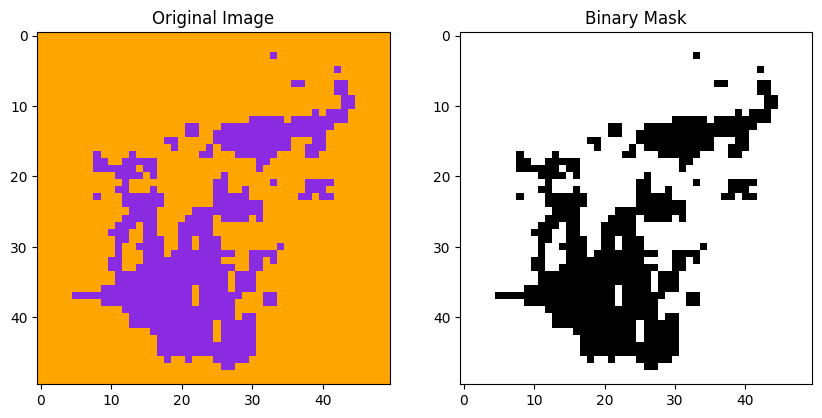

In [2]:
border_img = iio.imread("dataset/Q1/border.png")
# orange = [255,165,0]
# purple = [138  43 226]
def image_to_binary_mask(img:np.ndarray)->np.ndarray:
    """
    Convert the border image to a binary mask.
    Orange (Netherlands) -> 1
    Purple (Belgium) -> 0
    """

    # Correct RGB values
    orange = np.array([255, 165, 0])   # Netherlands
    purple = np.array([138, 43, 226])  # Belgium

    # Compute Euclidean distance to each color
    dist_orange = np.linalg.norm(img - orange, axis=-1)
    dist_purple = np.linalg.norm(img - purple, axis=-1)

    # Assign label 1 for closer to orange, else 0
    mask = (dist_orange < dist_purple).astype(np.uint8)

    return mask
mask = image_to_binary_mask(border_img)
baseline = (np.sum(mask) /( mask.shape[0]*mask.shape[1]))

print(f"baseline accuracy : {baseline*100} %")

fig , axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(border_img)
axes[0].set_title("Original Image")
axes[1].imshow(mask,cmap='gray')
axes[1].set_title("Binary Mask")
plt.show()

In [3]:
class BorderDataset:
    """
    Dataset class for the Belgium-Netherlands border classification task.
    Returns pixels with normalized coordinates and corresponding labels.
    """
    def __init__(self, binary_mask):
        """
        Initialize the dataset with the binary mask.
        """
        self.binary_mask = binary_mask
        self.height, self.width = binary_mask.shape
        # Create coordinate arrays
        y_coords, x_coords = np.indices((self.height, self.width))
        # Normalize to [0, 1]
        self.x_normalized = x_coords.flatten() / (self.width - 1)
        self.y_normalized = y_coords.flatten() / (self.height - 1)
        self.labels = binary_mask.flatten()
        # Create indices for shuffling
        self.indices = np.arange(len(self.labels))
    
    def shuffle(self):
        """Shuffle the dataset order."""
        # Set seed for reproducible shuffling
        np.random.seed(42)
        np.random.shuffle(self.indices)
        
    def get_all_samples(self):
        """
        Get all data points in shuffled order.
        """
        self.shuffle()
        coordinates = np.column_stack([
            self.x_normalized[self.indices], 
            self.y_normalized[self.indices]
        ])
        labels = self.labels[self.indices]
        return coordinates, labels
    
    def reconstruct_image_from_predictions(self, shuffled_predictions):
        """
        Reconstruct image from shuffled predictions by mapping them back to original positions.
        """
        # Create empty array for reconstructed image
        reconstructed = np.zeros(self.height * self.width)
        
        # Map shuffled predictions back to original positions
        reconstructed[self.indices] = shuffled_predictions.flatten()
        
        # Reshape to original image dimensions
        return reconstructed.reshape(self.height, self.width)
    
dataset = BorderDataset(mask)

# Map Prediction and Analysis

In [4]:
def run_model_on_border(layers , loss_fn , learning_rate=0.01 , max_epochs=1000 , mask=mask , batch_size=4 ,patience=100,run_name="sample_run",save_model=True,rel_loss_threshold=1e-6,learning_rate_=0.01):
    """
    Create and train the model with given layers and loss function.
    """
    for layer in layers:
        layer.learning_rate = learning_rate
        
    model = Model(layers, loss_fn)
    print(f"Model created with {model.get_parameter_count()} parameters.")
    dataset = BorderDataset(mask)

    results = train_model(
        model=model,
        dataset=dataset,
        batch_size=batch_size,
        max_epochs=max_epochs,
        patience=patience,
        save_model=save_model,
        run_name=run_name,
        relative_loss_threshold=rel_loss_threshold,
        use_wandb=False
    )

    X,Y = dataset.get_all_samples()
    predictions = model.predict(X)
    threshold = 0.5  
    predicted_labels = (predictions > threshold).astype(int).flatten()

    true_labels = Y.flatten()

    # the ground truth map
    true_map = dataset.reconstruct_image_from_predictions(true_labels)

    # map generated from model predictions
    pred_map = dataset.reconstruct_image_from_predictions(predicted_labels)

    error_map = dataset.reconstruct_image_from_predictions((true_labels != predicted_labels).astype(int))

    # Error map
    height, width = dataset.height, dataset.width
    error_overlay = np.zeros((height, width, 3))
    error_overlay[:,:,0] = true_map  # Red channel = ground truth
    error_overlay[:,:,1] = true_map  # Green channel = ground truth  
    error_overlay[:,:,2] = true_map  # Blue channel = ground truth
    

    
    # Highlight errors in bright red
    error_overlay[error_map == 1] = [1, 0, 0]  # Bright red for errors

    check = (true_map == pred_map).astype(int)
    accuracy = np.sum(check) / check.size
    print(f"Model accuracy: {accuracy * 100:.2f}%")

    fig , axes = plt.subplots(1,3,figsize=(10,5))
    axes[0].imshow(true_map)     
    axes[0].set_title("True Labels")    
    axes[1].imshow(pred_map,cmap='gray')
    axes[1].set_title("Predicted Labels")
    axes[2].imshow(error_overlay)
    axes[2].set_title("Error Map")
    plt.show()
    # save the following images side-by-side in a single plot within the run folder
    fig.savefig(f"runs/{run_name}/results.png")

    return {
        "accuracy": accuracy,
        "final_loss": results['final_loss'],
        "samples_seen" :results['samples_seen'],
    }

In [5]:

test_architectures = [
    ([Linear(2, 16, ReLU()), Linear(16, 1, Sigmoid())], BCELoss()),
    ([Linear(2, 8, ReLU()),Linear(8, 8, ReLU()),Linear(8, 8, ReLU()), Linear(8, 1, Sigmoid())], MSELoss()),
    ([Linear(2, 16, ReLU()), Linear(16, 1, Tanh())], BCELoss()),
    ([Linear(2, 8, Identity()),Linear(8, 8, ReLU()),Linear(8, 8, ReLU()), Linear(8, 1, Tanh())], MSELoss()),
]

Running architecture 1/4
Model created with 65 parameters.
Starting training: border/architecture_1
Early stopping at epoch 3358
Training completed: 3359 epochs, 8397500 samples
Final loss: 0.269903


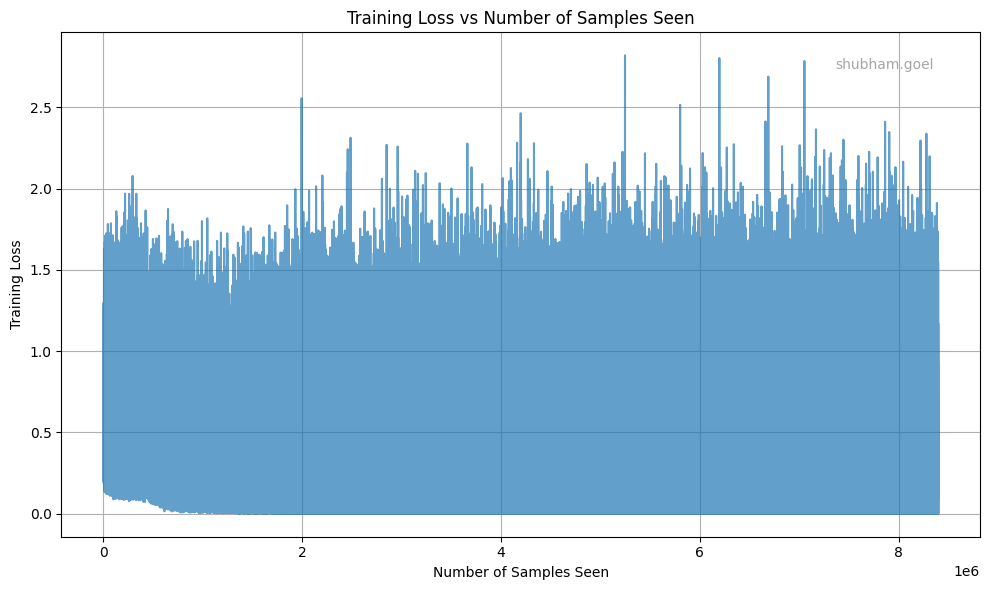

Results saved to runs/border/architecture_1/
Model accuracy: 85.68%


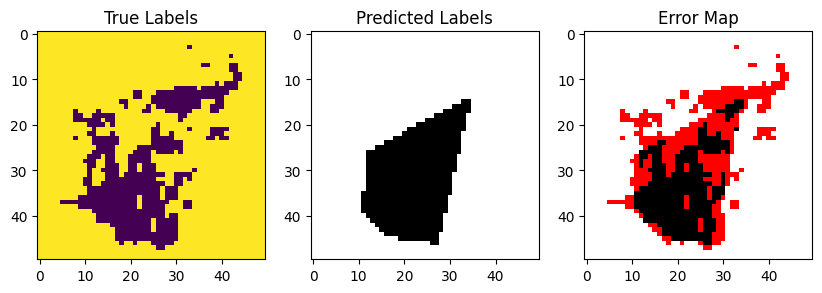

Running architecture 2/4
Model created with 177 parameters.
Starting training: border/architecture_2
Early stopping at epoch 2179
Training completed: 2180 epochs, 5450000 samples
Final loss: 0.040598


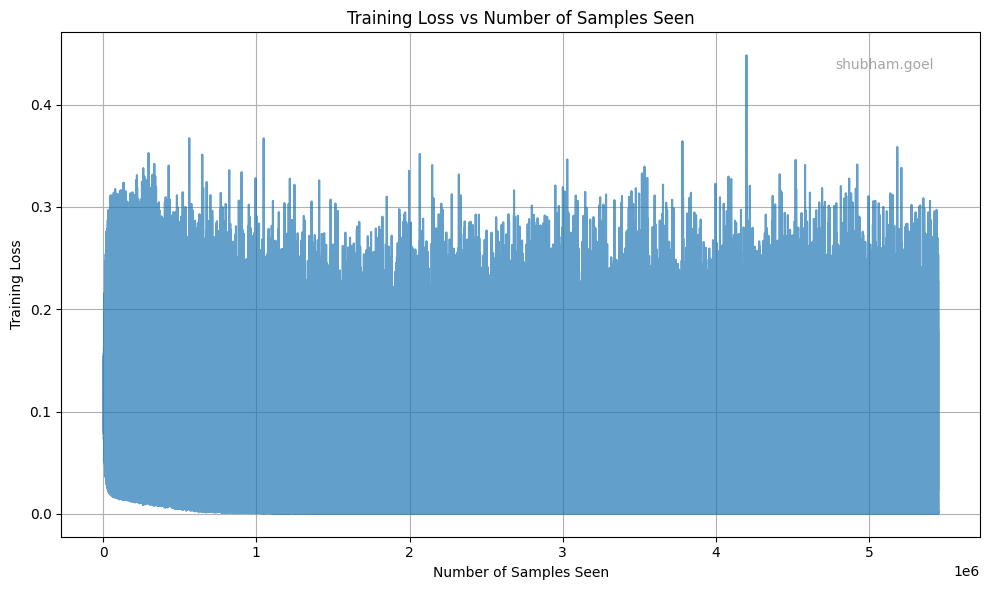

Results saved to runs/border/architecture_2/
Model accuracy: 88.64%


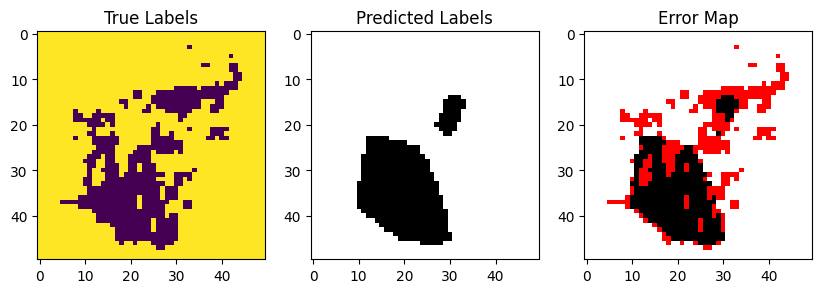

Running architecture 3/4
Model created with 65 parameters.
Starting training: border/architecture_3
Early stopping at epoch 501
Training completed: 502 epochs, 1255000 samples
Final loss: 7.101337


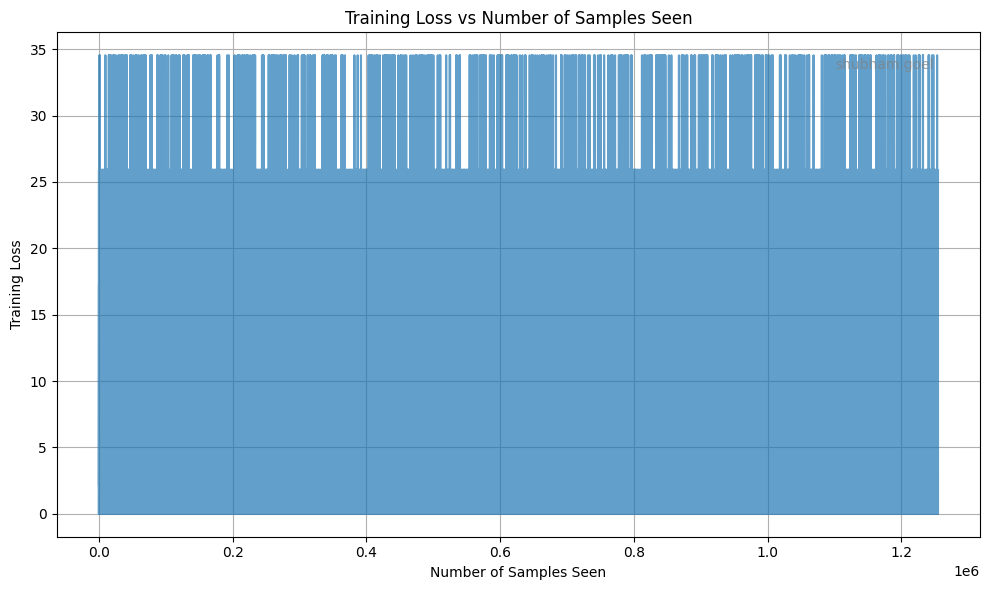

Results saved to runs/border/architecture_3/
Model accuracy: 79.44%


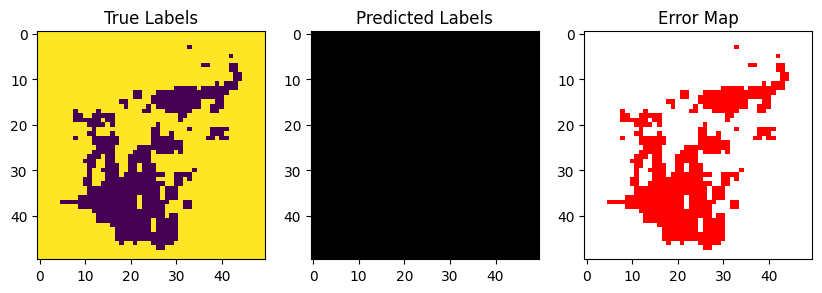

Running architecture 4/4
Model created with 177 parameters.
Starting training: border/architecture_4
Early stopping at epoch 3215
Training completed: 3216 epochs, 8040000 samples
Final loss: 0.031784


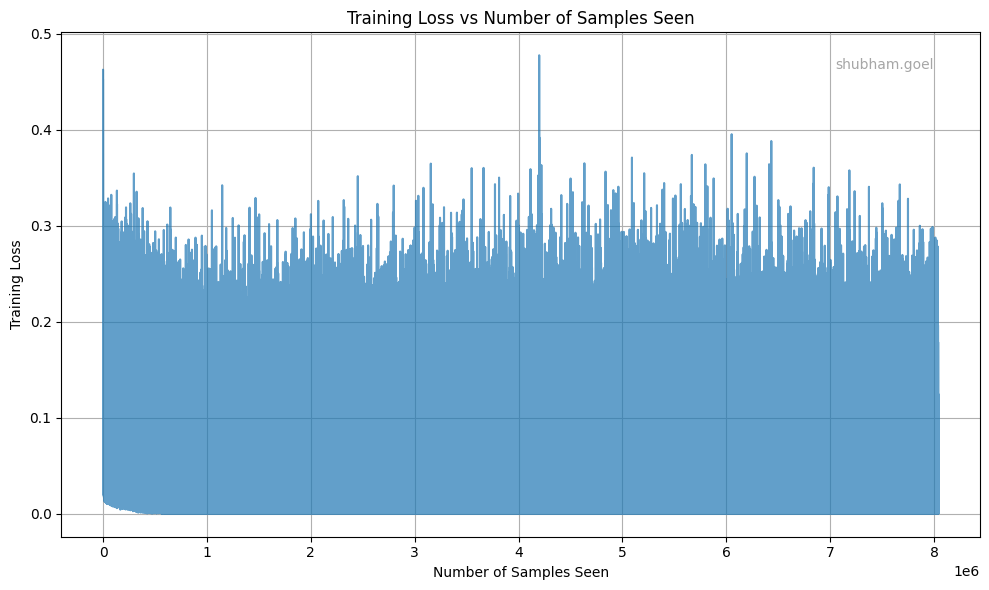

Results saved to runs/border/architecture_4/
Model accuracy: 91.36%


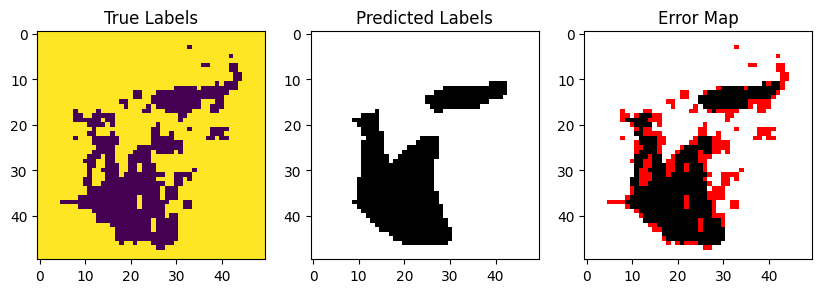

In [6]:
for i , (layers , loss_fn) in enumerate(test_architectures):
    print(f"Running architecture {i+1}/{len(test_architectures)}")

    result = run_model_on_border(
        layers=layers,
        loss_fn=loss_fn,
        learning_rate=0.01,
        max_epochs=10000,
        mask=mask,
        batch_size=4,
        patience=500,
        rel_loss_threshold=1e-6,
        run_name=f"border/architecture_{i+1}",
        save_model=True
    )
    # print(f"train_loss: {result['final_loss']}, accuracy: {result['accuracy']*100:.2f}%")

##  Experimentation with Architecture:

### For a fixed layer width, vary the number of layers. Plot the final loss and accuracy as a function of depth.

Running architecture with 1 hidden layers
Model created with 33 parameters.
Starting training: border/hidden_layers_1
Early stopping at epoch 2179
Training completed: 2180 epochs, 5450000 samples
Final loss: 0.289007


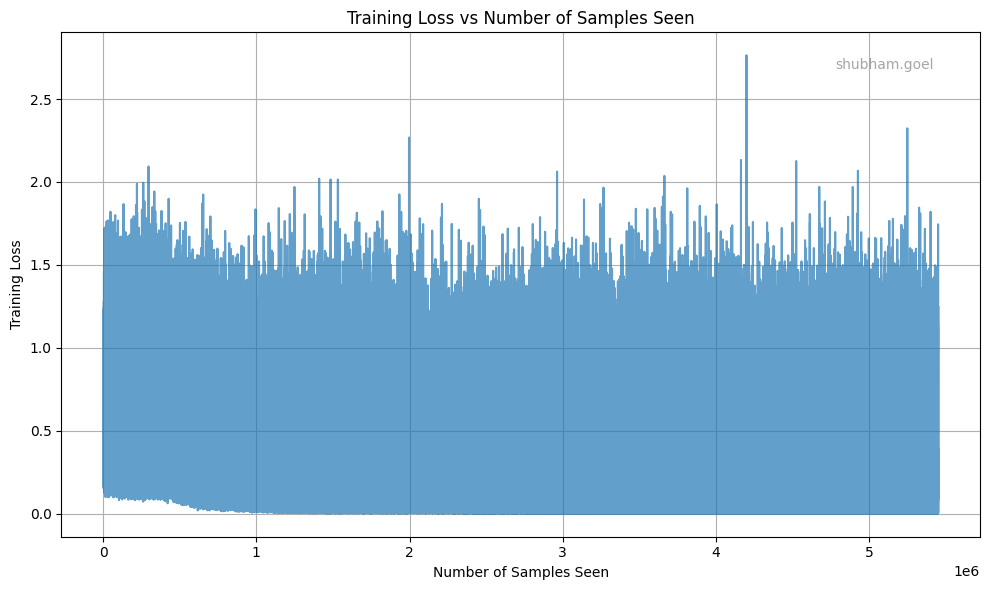

Results saved to runs/border/hidden_layers_1/
Model accuracy: 85.56%


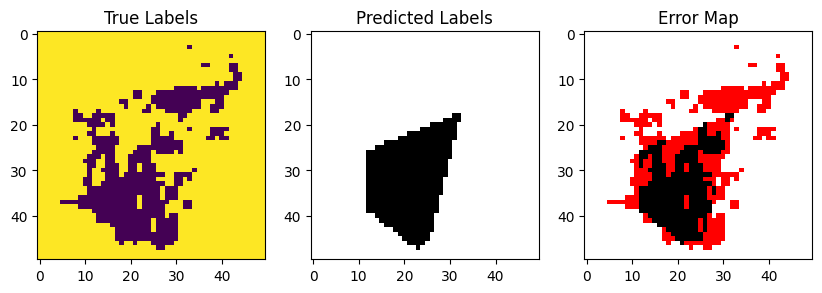

Running architecture with 2 hidden layers
Model created with 105 parameters.
Starting training: border/hidden_layers_2
Early stopping at epoch 1807
Training completed: 1808 epochs, 4520000 samples
Final loss: 0.226801


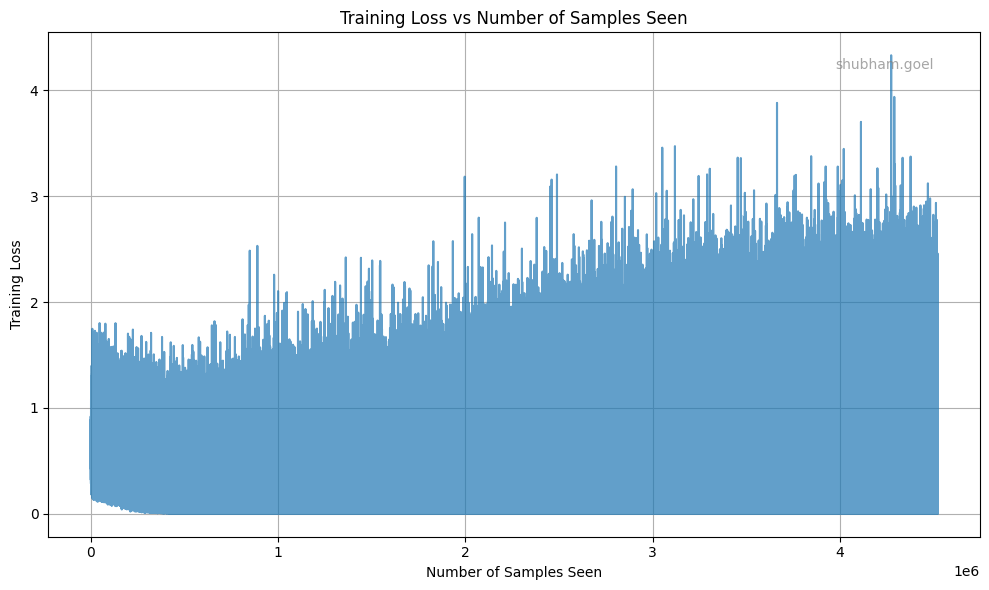

Results saved to runs/border/hidden_layers_2/
Model accuracy: 90.76%


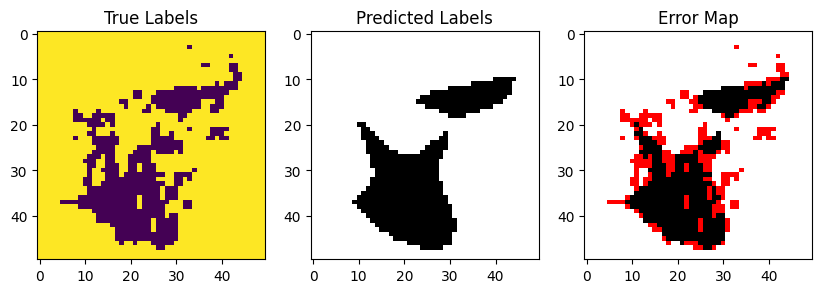

Running architecture with 3 hidden layers
Model created with 177 parameters.
Starting training: border/hidden_layers_3
Early stopping at epoch 1251
Training completed: 1252 epochs, 3130000 samples
Final loss: 0.234166


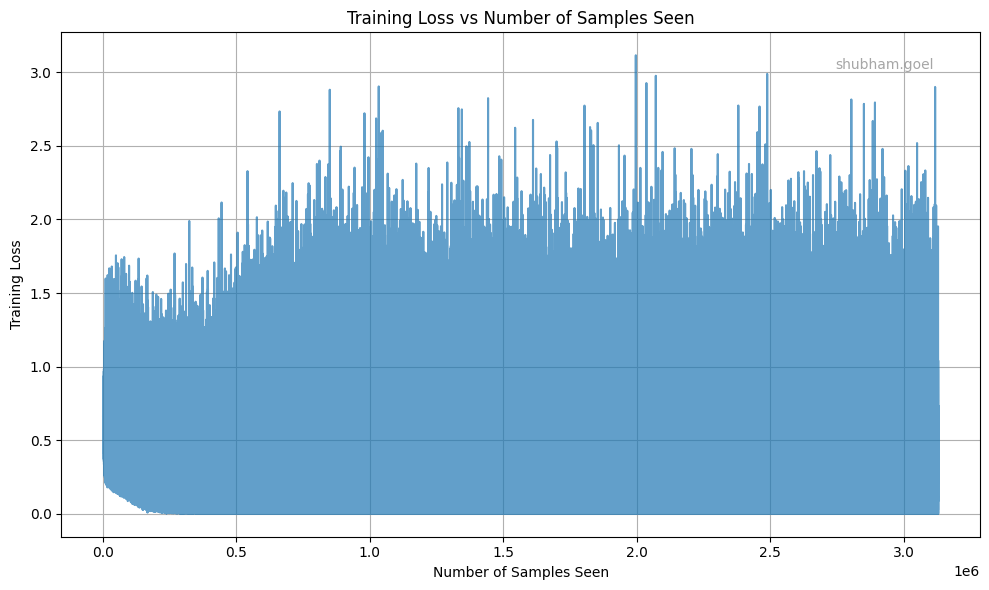

Results saved to runs/border/hidden_layers_3/
Model accuracy: 89.04%


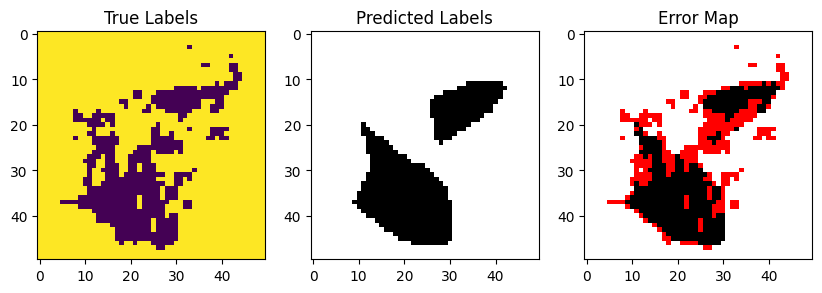

Running architecture with 4 hidden layers
Model created with 249 parameters.
Starting training: border/hidden_layers_4
Early stopping at epoch 2119
Training completed: 2120 epochs, 5300000 samples
Final loss: 0.194813


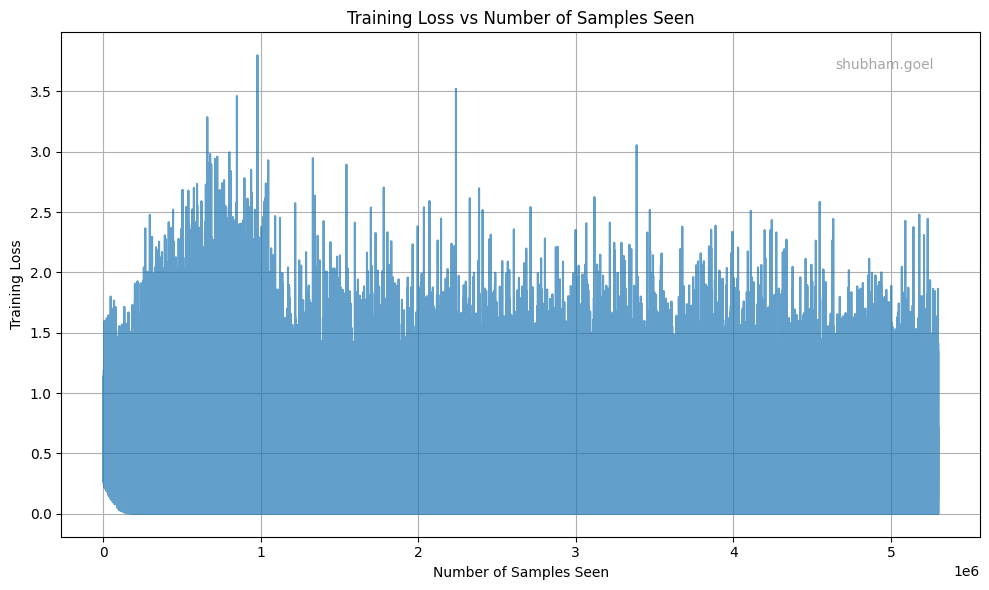

Results saved to runs/border/hidden_layers_4/
Model accuracy: 91.56%


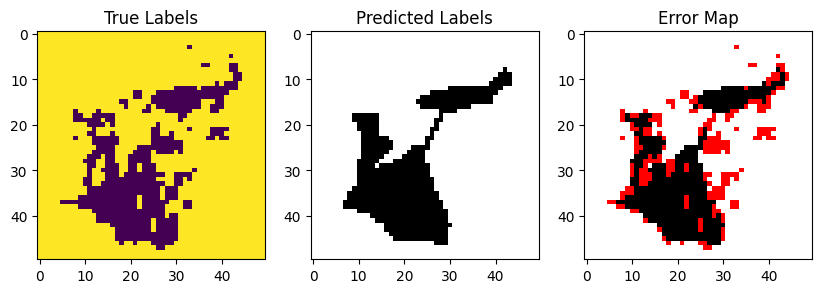

Running architecture with 5 hidden layers
Model created with 321 parameters.
Starting training: border/hidden_layers_5
Early stopping at epoch 1575
Training completed: 1576 epochs, 3940000 samples
Final loss: 0.228619


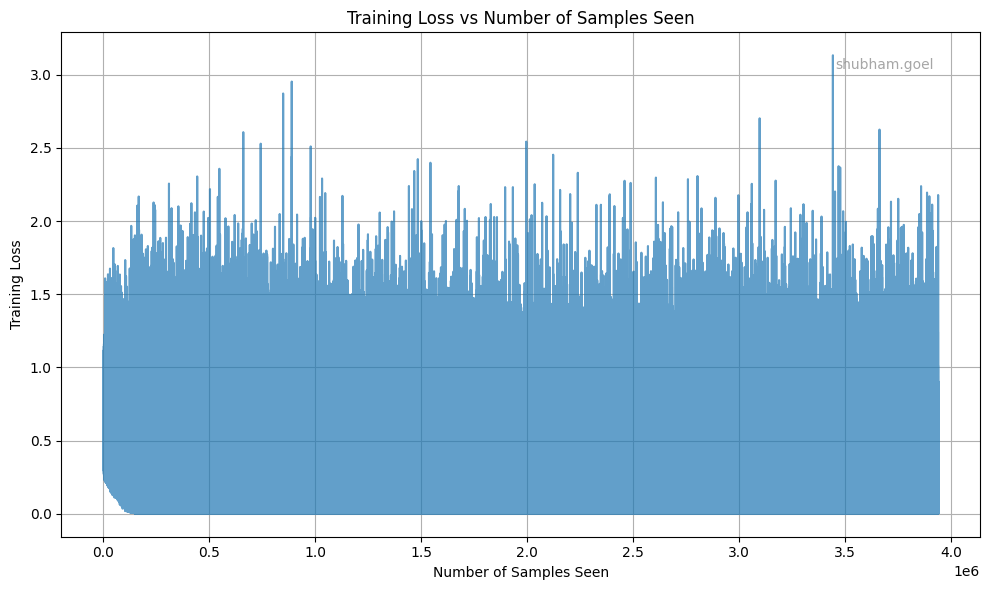

Results saved to runs/border/hidden_layers_5/
Model accuracy: 90.28%


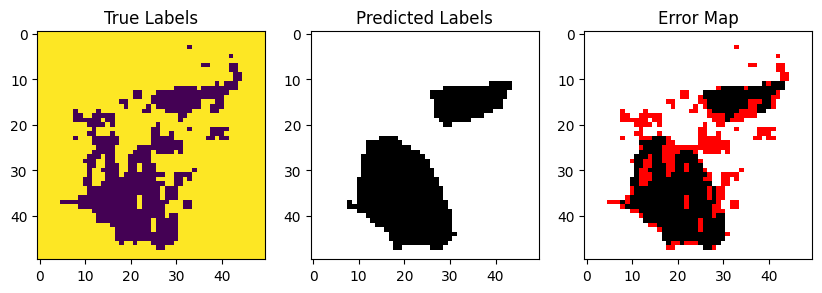

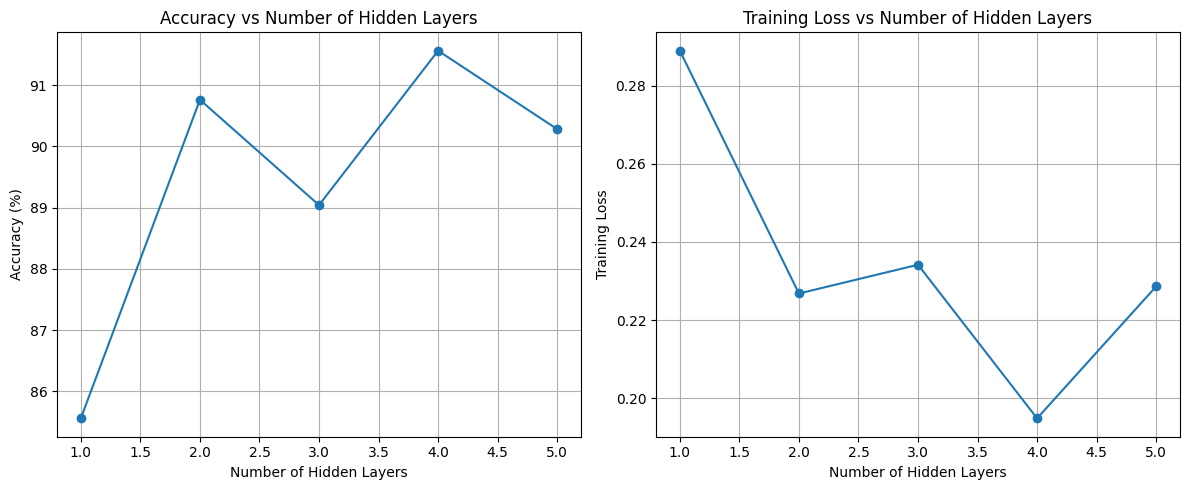

In [8]:
HIDDEN_SIZE = 8
OUTPUT_SIZE = 1
MAX_NUM_OF_HIDDEN_LAYERS = 5

accuracy_results = []
train_losses = []
for i in range(1, MAX_NUM_OF_HIDDEN_LAYERS + 1):
    layers = []
    # Input layer
    layers.append(Linear(input_size=2, output_size=HIDDEN_SIZE, activation_function=ReLU(), learning_rate=0.01))
    
    # Hidden layers
    for _ in range(i - 1):
        layers.append(Linear(input_size=HIDDEN_SIZE, output_size=HIDDEN_SIZE, activation_function=ReLU(), learning_rate=0.01))
    
    # Output layer
    layers.append(Linear(input_size=HIDDEN_SIZE, output_size=OUTPUT_SIZE, activation_function=Sigmoid(), learning_rate=0.01))
    
    print(f"Running architecture with {i} hidden layers")
    
    result = run_model_on_border(
        layers=layers,
        loss_fn=BCELoss(),
        learning_rate=0.01,
        max_epochs=10000,
        mask=mask,
        batch_size=4,
        patience=500,
        rel_loss_threshold=1e-6,
        run_name=f"border/hidden_layers_{i}",
        save_model=True
    )

    accuracy_results.append(result['accuracy'] * 100)
    train_losses.append(result['final_loss'])

# Plotting accuracy and training loss vs number of hidden layers
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, MAX_NUM_OF_HIDDEN_LAYERS + 1), accuracy_results, marker='o')
plt.title("Accuracy vs Number of Hidden Layers")
plt.xlabel("Number of Hidden Layers")
plt.ylabel("Accuracy (%)")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(1, MAX_NUM_OF_HIDDEN_LAYERS + 1), train_losses, marker='o')
plt.title("Training Loss vs Number of Hidden Layers")
plt.xlabel("Number of Hidden Layers")
plt.ylabel("Training Loss")
plt.grid()

plt.tight_layout()
plt.show()

### For a fixed number of layers, vary the width of the layers. Plot the final loss and accuracy as a function of width.

Running architecture with width 5
Model created with 23 parameters.
Starting training: border/width_5
Early stopping at epoch 1438
Training completed: 1439 epochs, 3597500 samples
Final loss: 0.295001


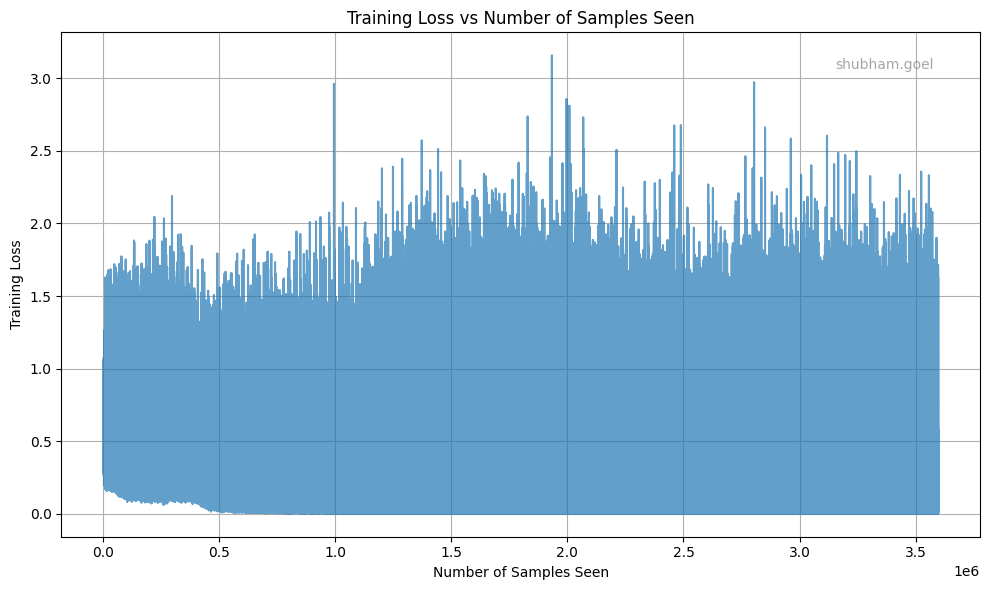

Results saved to runs/border/width_5/
Model accuracy: 84.48%


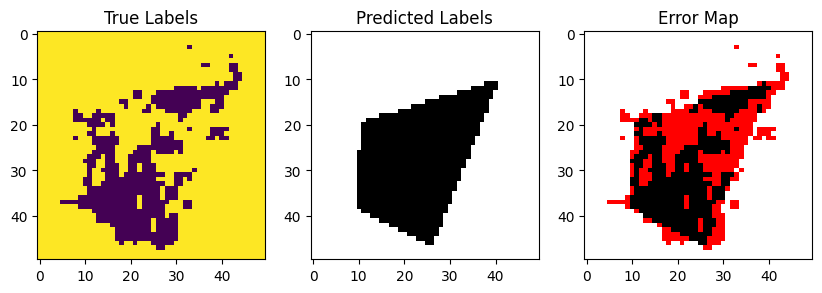

Running architecture with width 5
Model created with 44 parameters.
Starting training: border/width_5
Early stopping at epoch 1175
Training completed: 1176 epochs, 2940000 samples
Final loss: 0.287725


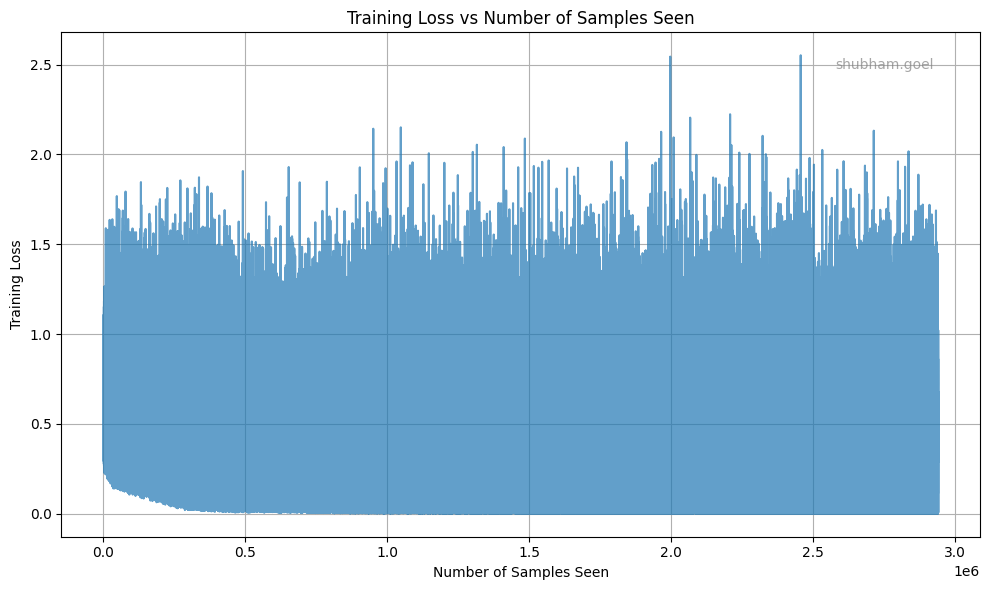

Results saved to runs/border/width_5/
Model accuracy: 86.20%


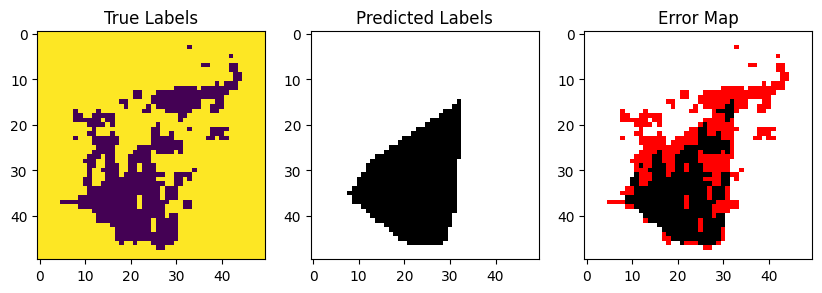

Running architecture with width 5
Model created with 65 parameters.
Starting training: border/width_5
Early stopping at epoch 1327
Training completed: 1328 epochs, 3320000 samples
Final loss: 0.271602


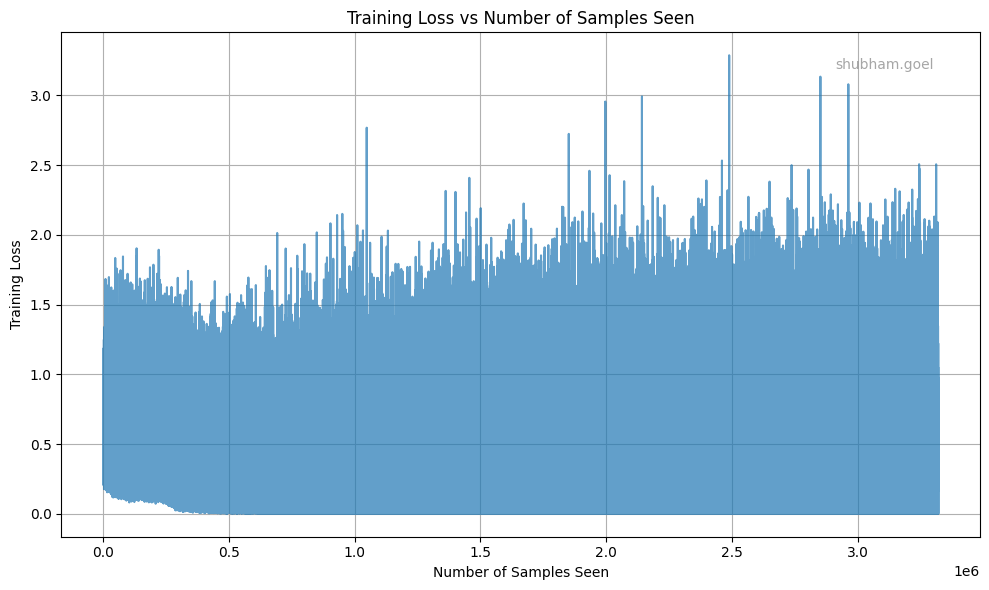

Results saved to runs/border/width_5/
Model accuracy: 86.20%


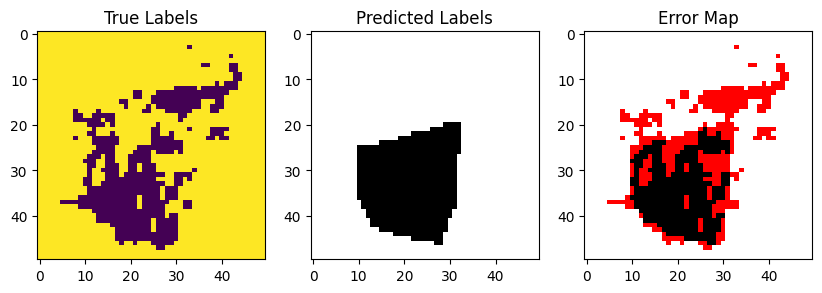

Running architecture with width 5
Model created with 86 parameters.
Starting training: border/width_5
Early stopping at epoch 2535
Training completed: 2536 epochs, 6340000 samples
Final loss: 0.240708


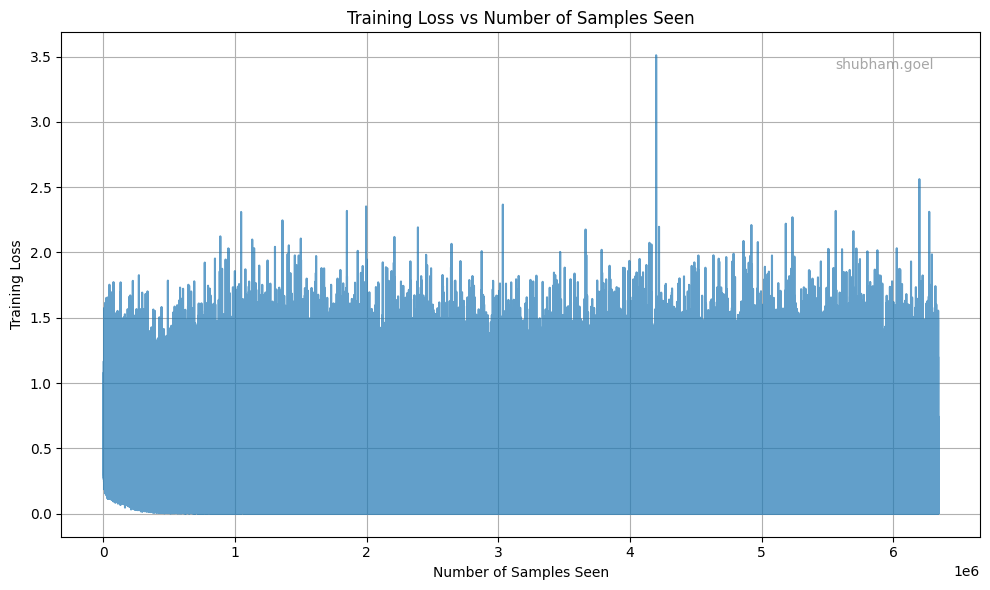

Results saved to runs/border/width_5/
Model accuracy: 88.72%


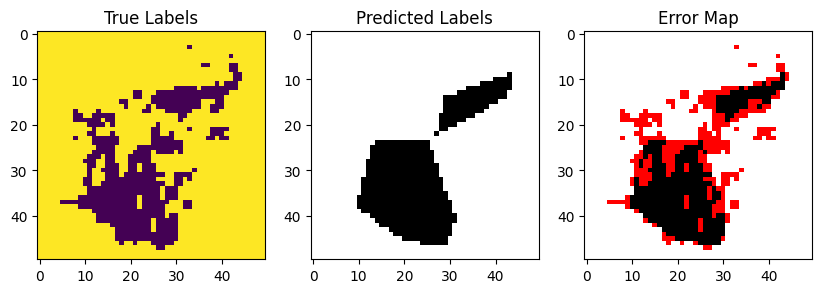

Running architecture with width 5
Model created with 107 parameters.
Starting training: border/width_5
Early stopping at epoch 2179
Training completed: 2180 epochs, 5450000 samples
Final loss: 0.255283


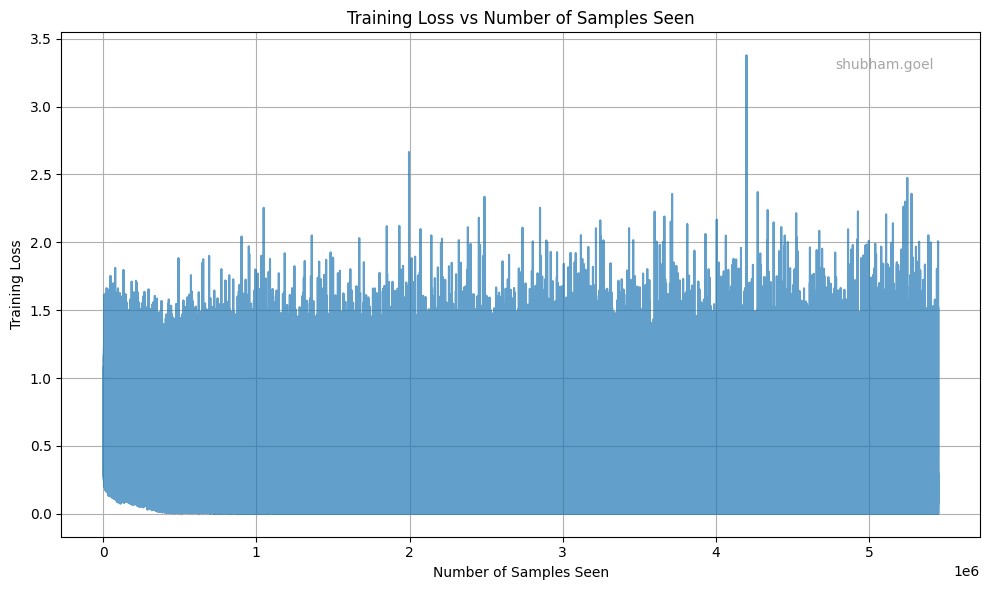

Results saved to runs/border/width_5/
Model accuracy: 87.48%


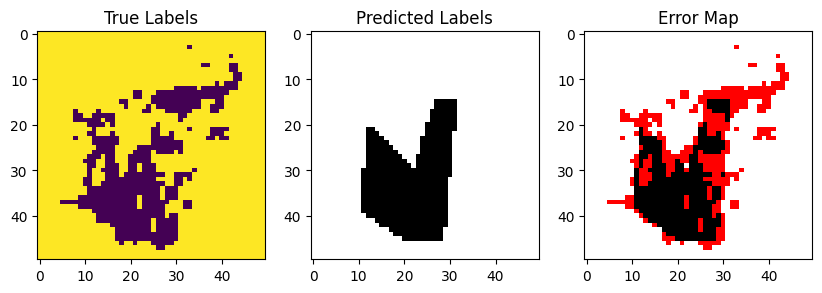

Running architecture with width 5
Model created with 128 parameters.
Starting training: border/width_5
Early stopping at epoch 3972
Training completed: 3973 epochs, 9932500 samples
Final loss: 0.226121


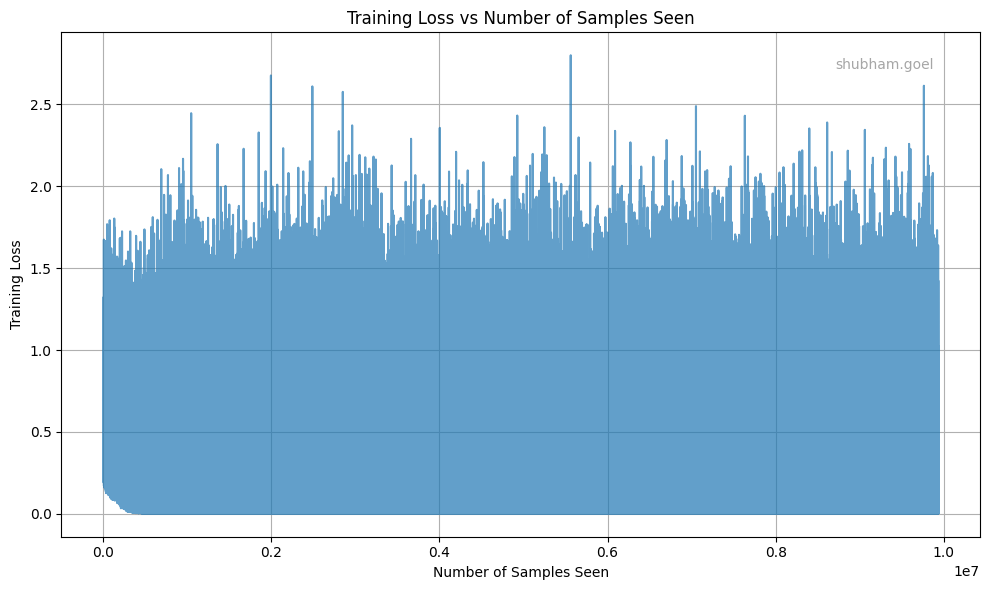

Results saved to runs/border/width_5/
Model accuracy: 90.20%


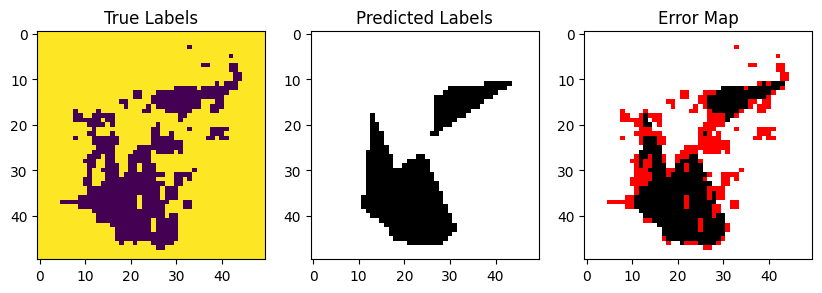

Running architecture with width 5
Model created with 149 parameters.
Starting training: border/width_5
Early stopping at epoch 1456
Training completed: 1457 epochs, 3642500 samples
Final loss: 0.232868


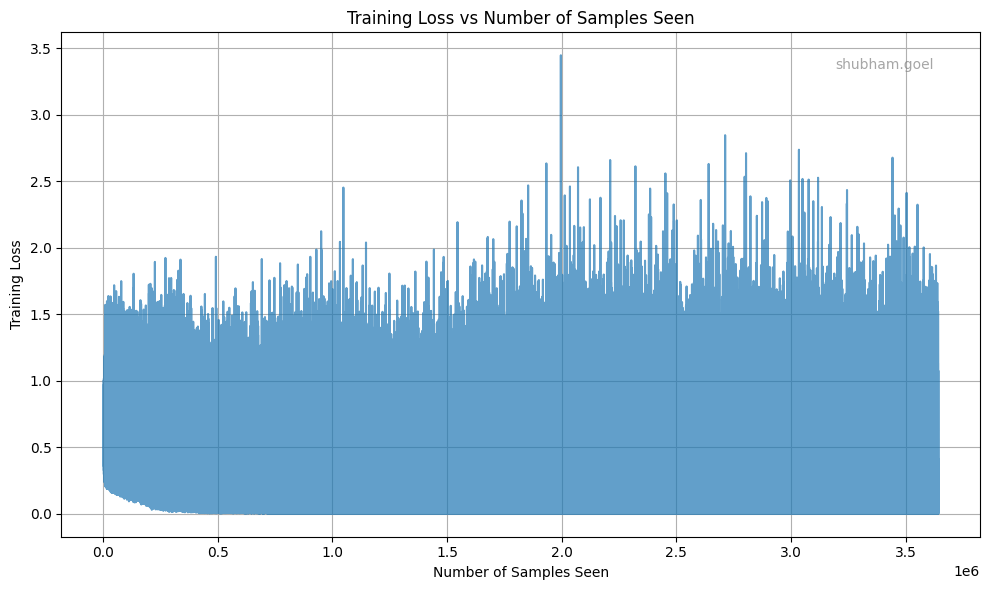

Results saved to runs/border/width_5/
Model accuracy: 89.64%


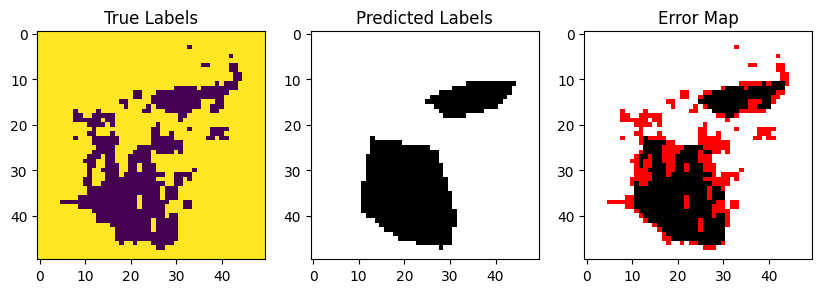

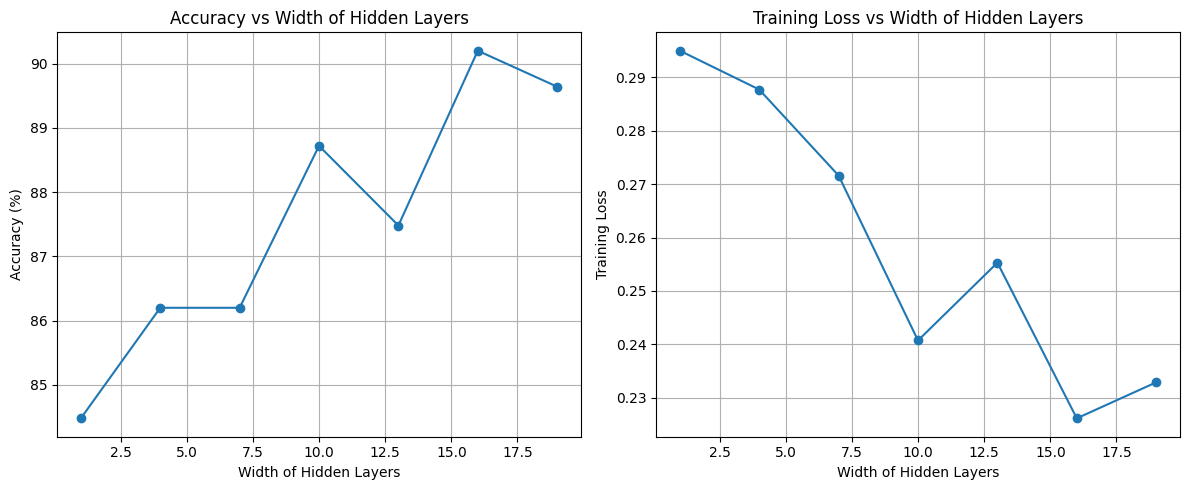

In [9]:
MAX_NUM_OF_HIDDEN_LAYERS = 2
MAX_WIDTH = 20
HIDDEN_SIZE = 8
OUTPUT_SIZE = 1

accuracy_results = []
train_losses = []

for width in range(1, MAX_WIDTH + 1, 3):
    layers = []
    # Input layer
    layers.append(Linear(input_size=2, output_size=i, activation_function=ReLU(), learning_rate=0.01))
    
    # Hidden layers
    for _ in range(MAX_NUM_OF_HIDDEN_LAYERS - 1):
        layers.append(Linear(input_size=i, output_size=width, activation_function=ReLU(), learning_rate=0.01))
    
    # Output layer
    layers.append(Linear(input_size=width, output_size=OUTPUT_SIZE, activation_function=Sigmoid(), learning_rate=0.01))
    
    print(f"Running architecture with width {width}")
    
    result = run_model_on_border(
        layers=layers,
        loss_fn=BCELoss(),
        learning_rate=0.01,
        max_epochs=10000,
        mask=mask,
        batch_size=4,
        patience=500,
        rel_loss_threshold=1e-6,
        run_name=f"border/width_{i}",
        save_model=True
    )

    accuracy_results.append(result['accuracy'] * 100)
    train_losses.append(result['final_loss'])

# Plotting accuracy and training loss vs width of hidden layers
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, MAX_WIDTH + 1, 3), accuracy_results, marker='o')
plt.title("Accuracy vs Width of Hidden Layers")
plt.xlabel("Width of Hidden Layers")
plt.ylabel("Accuracy (%)")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(1, MAX_WIDTH + 1, 3), train_losses, marker='o')
plt.title("Training Loss vs Width of Hidden Layers")
plt.xlabel("Width of Hidden Layers")
plt.ylabel("Training Loss")
plt.grid()

plt.tight_layout()
plt.show()


### Experimentation with Hyperparameters:

* Train with a variety of batch size, grad accumulation steps, and learning
rates.
* Provide a comparison of the time taken to converge and the total number of
samples needed to converge for different hyperparameter settings.

Running with batch size 4 and grad accumulation 1
Model created with 105 parameters.
Starting training: border/batch_4_gradacc_1
Early stopping at epoch 1807
Training completed: 1808 epochs, 4520000 samples
Final loss: 0.226801


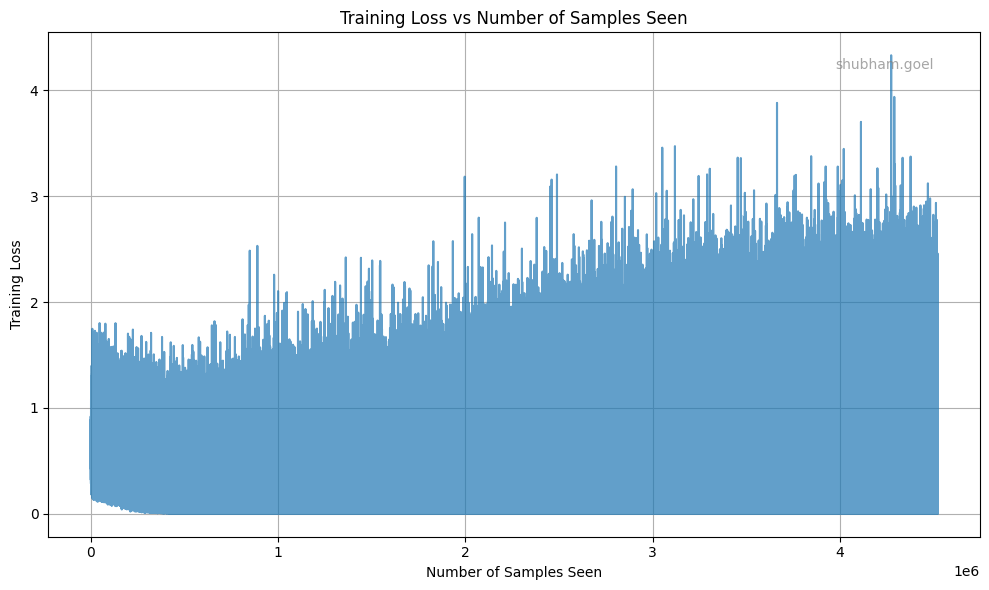

Results saved to runs/border/batch_4_gradacc_1/
Model accuracy: 90.76%


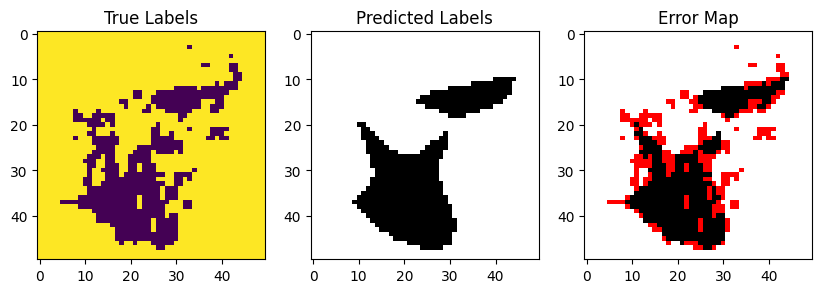

Time taken: 137.66 seconds
train_loss: 0.22680081186202583, accuracy: 90.76%
Running with batch size 4 and grad accumulation 2
Model created with 105 parameters.
Starting training: border/batch_4_gradacc_2
Early stopping at epoch 508
Training completed: 509 epochs, 1272500 samples
Final loss: 0.224041


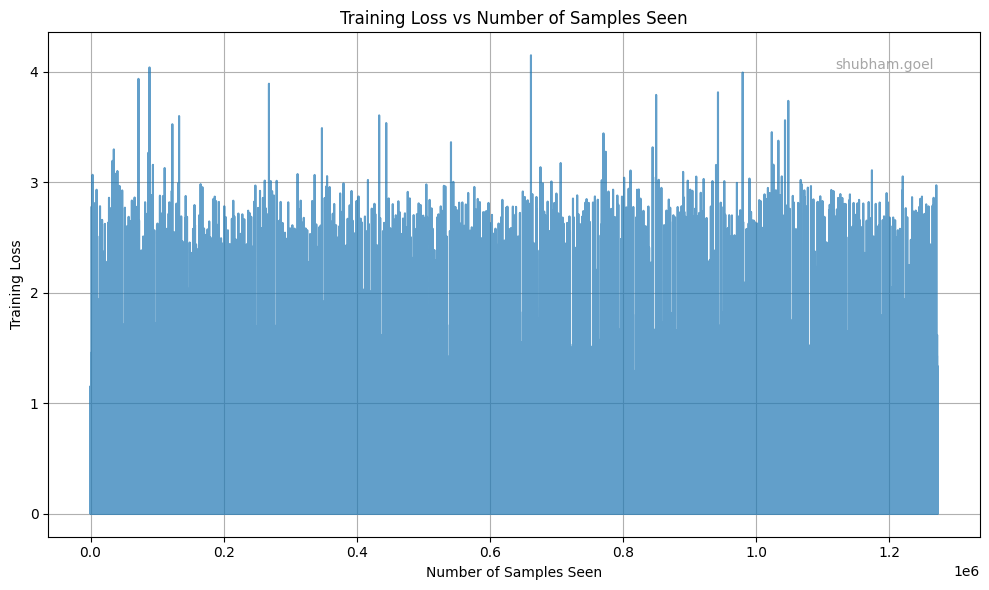

Results saved to runs/border/batch_4_gradacc_2/
Model accuracy: 91.20%


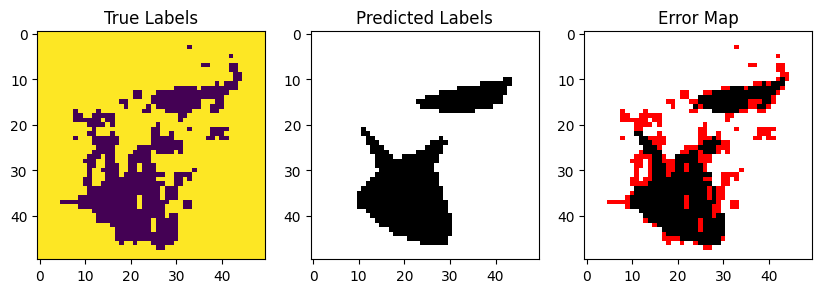

Time taken: 40.30 seconds
train_loss: 0.224041458877997, accuracy: 91.20%
Running with batch size 4 and grad accumulation 4
Model created with 105 parameters.
Starting training: border/batch_4_gradacc_4
Early stopping at epoch 507
Training completed: 508 epochs, 1270000 samples
Final loss: 0.222580


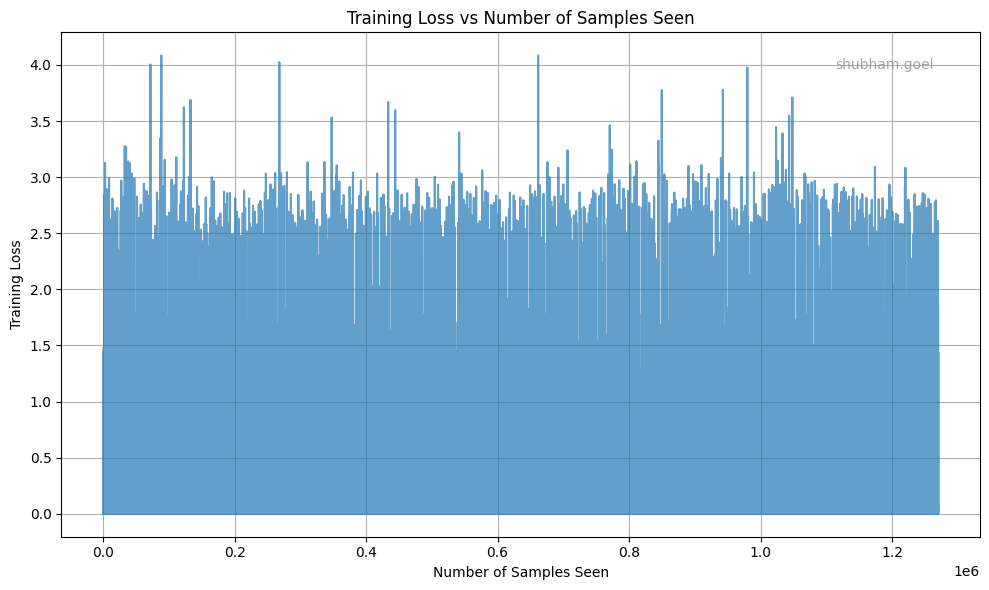

Results saved to runs/border/batch_4_gradacc_4/
Model accuracy: 91.00%


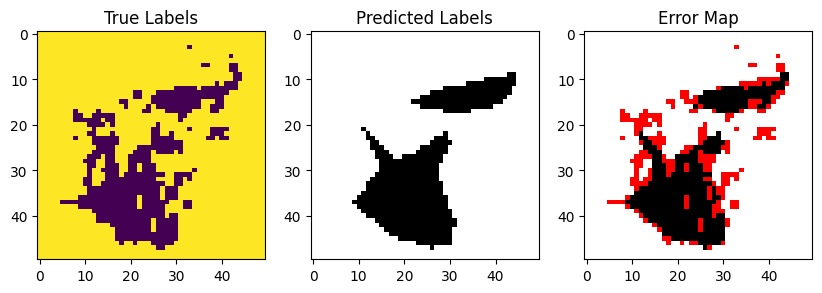

Time taken: 40.65 seconds
train_loss: 0.22258031833368513, accuracy: 91.00%
Running with batch size 4 and grad accumulation 8
Model created with 105 parameters.
Starting training: border/batch_4_gradacc_8
Early stopping at epoch 507
Training completed: 508 epochs, 1270000 samples
Final loss: 0.221042


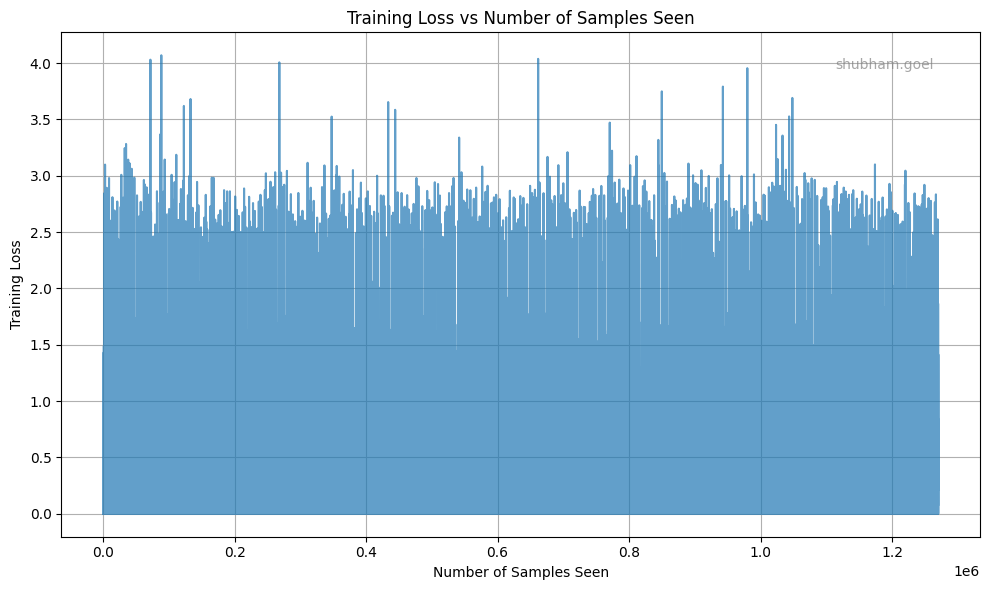

Results saved to runs/border/batch_4_gradacc_8/
Model accuracy: 91.24%


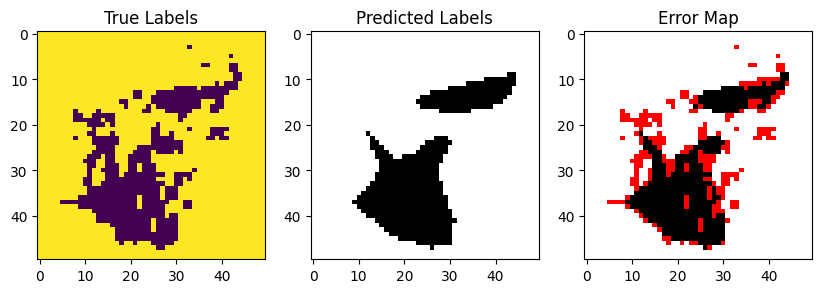

Time taken: 40.70 seconds
train_loss: 0.2210416769901549, accuracy: 91.24%
Running with batch size 16 and grad accumulation 1
Model created with 105 parameters.
Starting training: border/batch_16_gradacc_1
Early stopping at epoch 504
Training completed: 505 epochs, 1262500 samples
Final loss: 0.218867


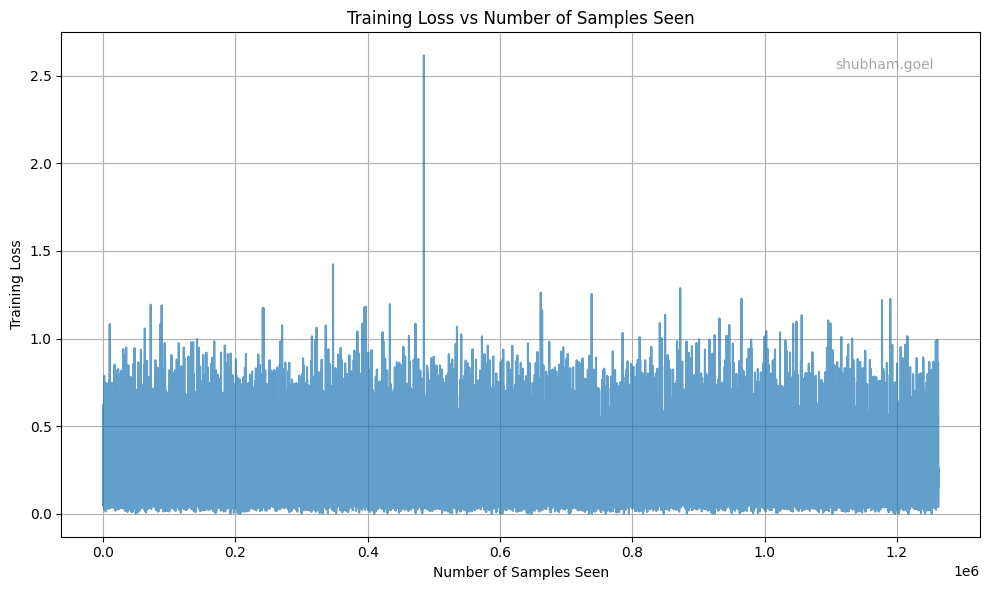

Results saved to runs/border/batch_16_gradacc_1/
Model accuracy: 91.24%


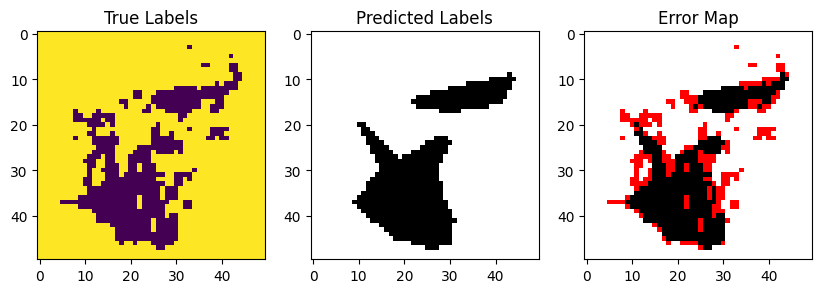

Time taken: 11.49 seconds
train_loss: 0.21886734139391167, accuracy: 91.24%
Running with batch size 16 and grad accumulation 2
Model created with 105 parameters.
Starting training: border/batch_16_gradacc_2
Early stopping at epoch 504
Training completed: 505 epochs, 1262500 samples
Final loss: 0.218773


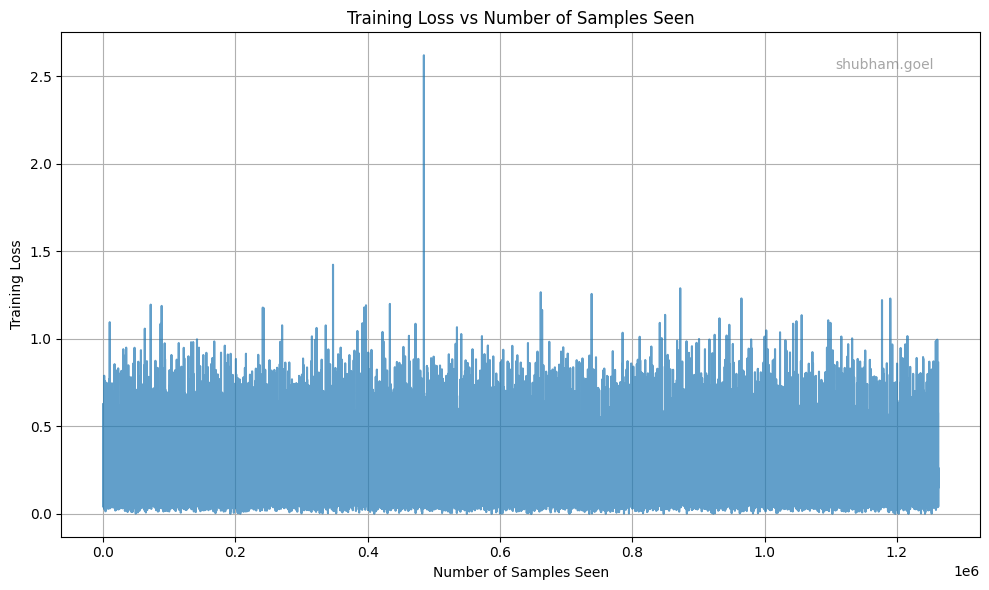

Results saved to runs/border/batch_16_gradacc_2/
Model accuracy: 91.24%


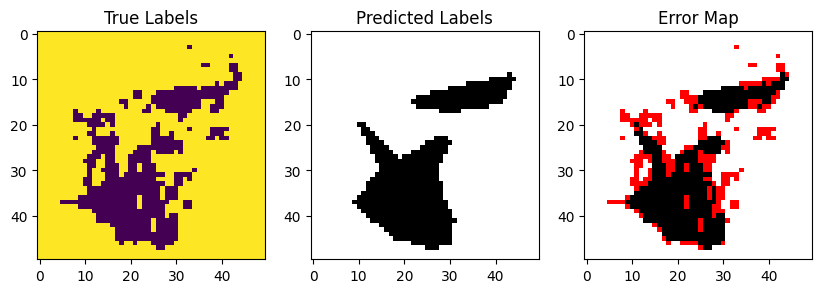

Time taken: 11.42 seconds
train_loss: 0.21877273511185874, accuracy: 91.24%
Running with batch size 16 and grad accumulation 4
Model created with 105 parameters.
Starting training: border/batch_16_gradacc_4
Early stopping at epoch 504
Training completed: 505 epochs, 1262500 samples
Final loss: 0.218712


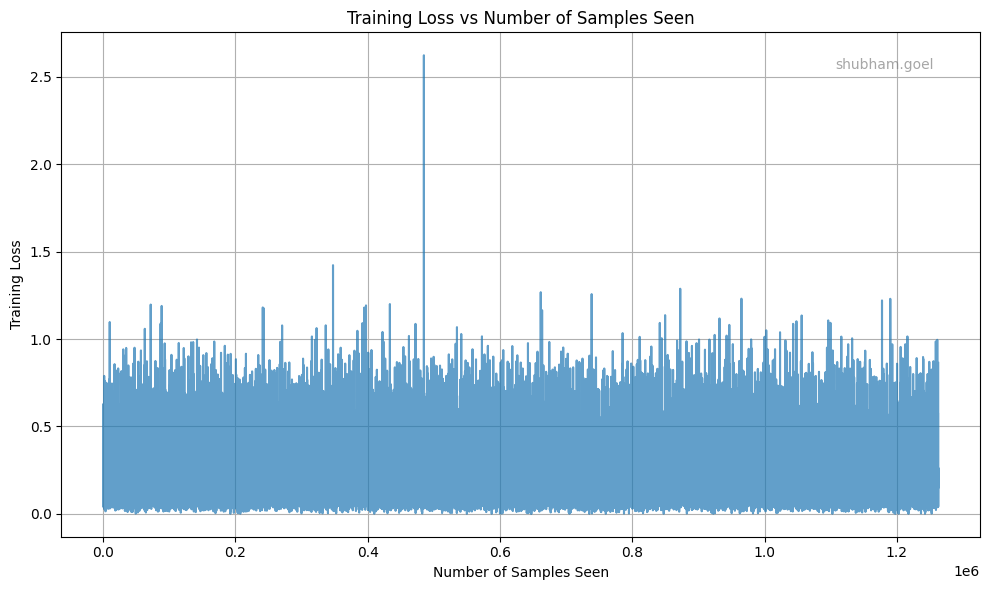

Results saved to runs/border/batch_16_gradacc_4/
Model accuracy: 91.24%


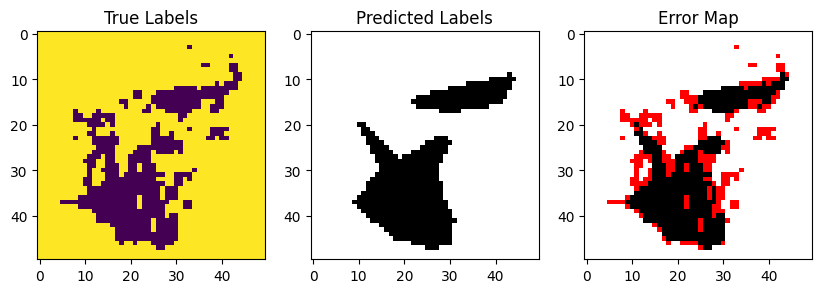

Time taken: 11.51 seconds
train_loss: 0.21871223189970798, accuracy: 91.24%
Running with batch size 16 and grad accumulation 8
Model created with 105 parameters.
Starting training: border/batch_16_gradacc_8
Early stopping at epoch 504
Training completed: 505 epochs, 1262500 samples
Final loss: 0.218646


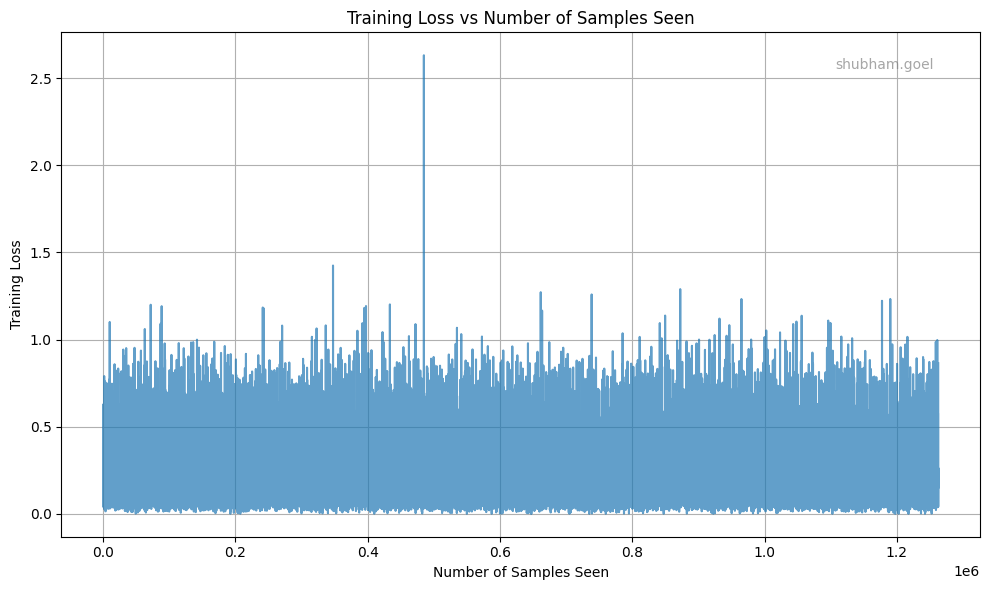

Results saved to runs/border/batch_16_gradacc_8/
Model accuracy: 91.24%


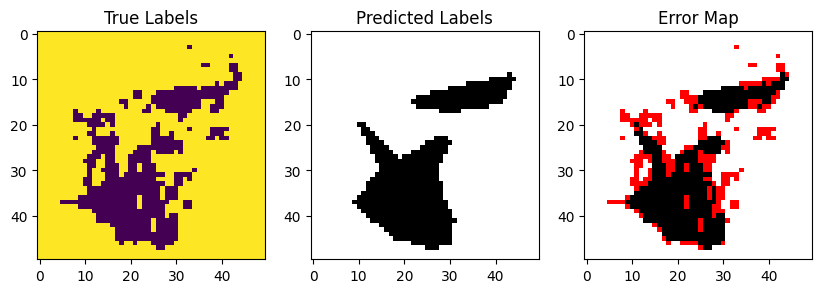

Time taken: 11.46 seconds
train_loss: 0.21864585904228126, accuracy: 91.24%
Running with batch size 64 and grad accumulation 1
Model created with 105 parameters.
Starting training: border/batch_64_gradacc_1
Early stopping at epoch 504
Training completed: 505 epochs, 1262500 samples
Final loss: 0.231155


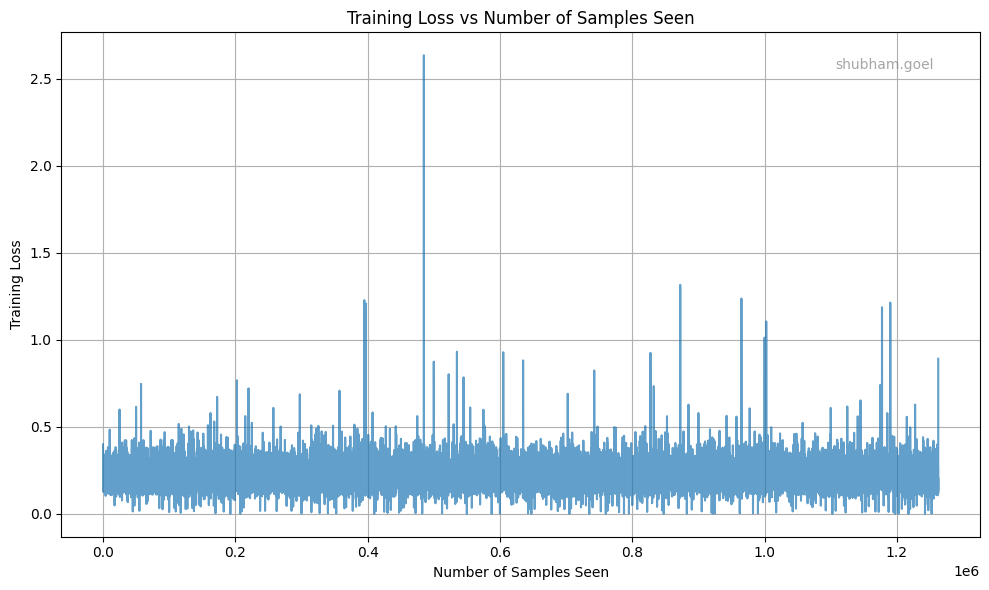

Results saved to runs/border/batch_64_gradacc_1/
Model accuracy: 91.28%


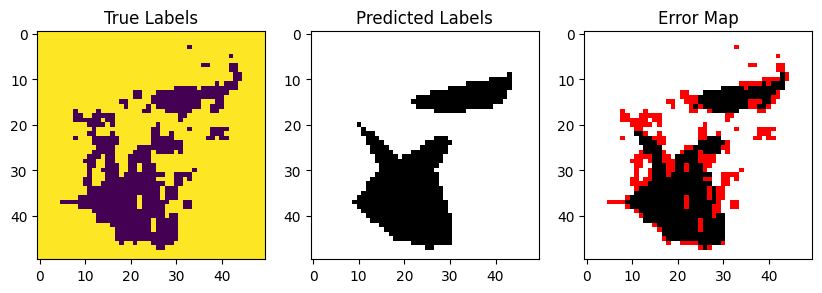

Time taken: 3.88 seconds
train_loss: 0.23115535548066557, accuracy: 91.28%
Running with batch size 64 and grad accumulation 2
Model created with 105 parameters.
Starting training: border/batch_64_gradacc_2
Early stopping at epoch 504
Training completed: 505 epochs, 1262500 samples
Final loss: 0.230949


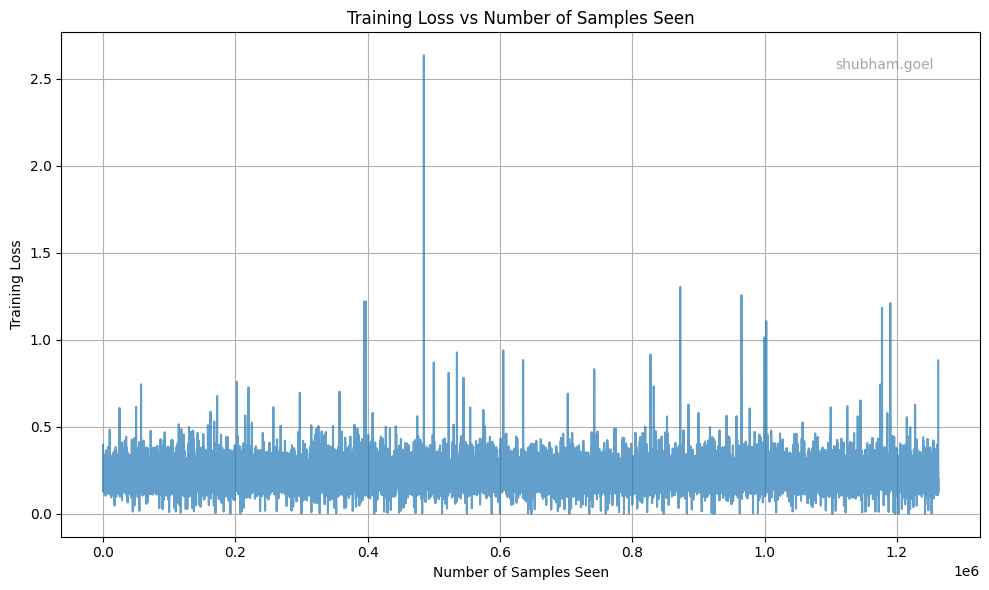

Results saved to runs/border/batch_64_gradacc_2/
Model accuracy: 91.28%


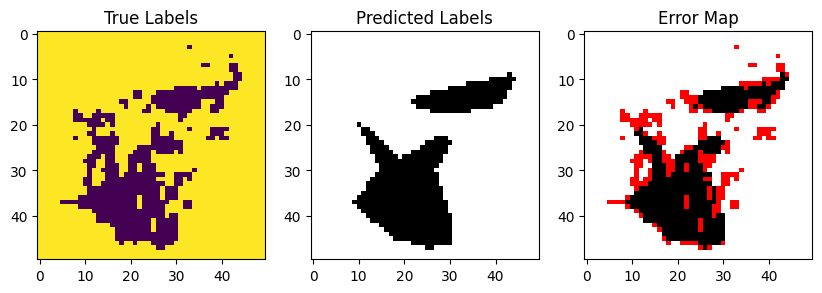

Time taken: 3.89 seconds
train_loss: 0.23094896886206842, accuracy: 91.28%
Running with batch size 64 and grad accumulation 4
Model created with 105 parameters.
Starting training: border/batch_64_gradacc_4
Early stopping at epoch 504
Training completed: 505 epochs, 1262500 samples
Final loss: 0.230877


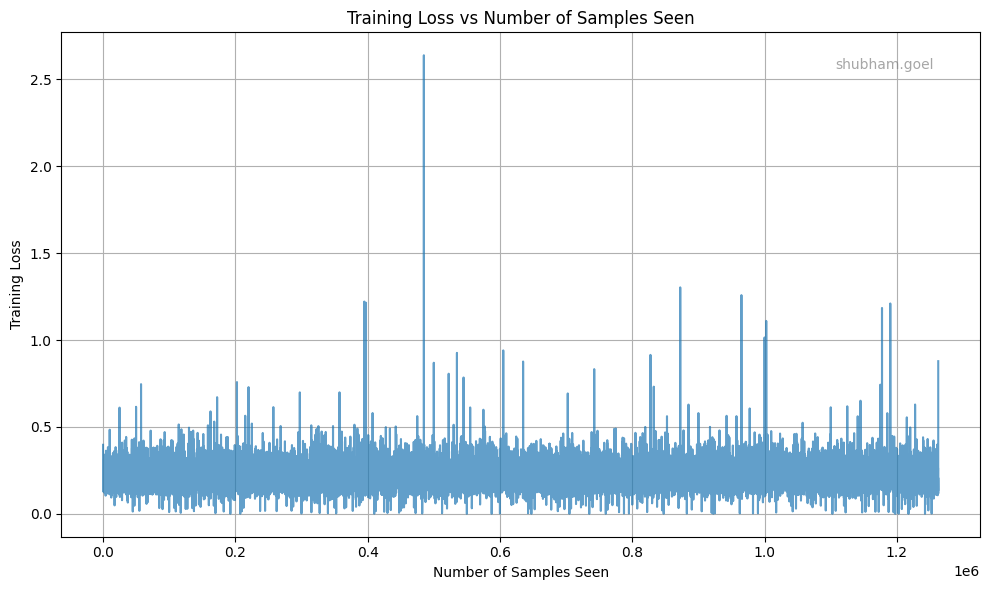

Results saved to runs/border/batch_64_gradacc_4/
Model accuracy: 91.36%


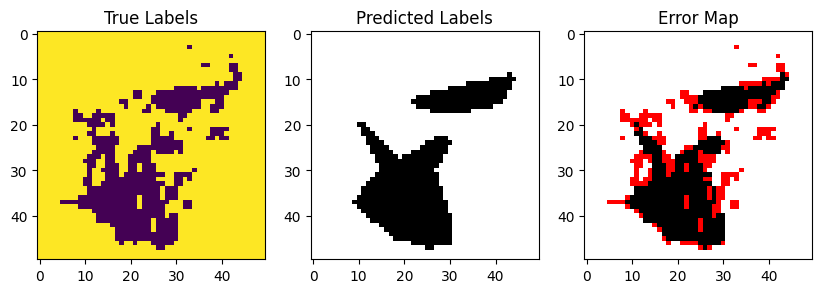

Time taken: 3.87 seconds
train_loss: 0.23087668488606067, accuracy: 91.36%
Running with batch size 64 and grad accumulation 8
Model created with 105 parameters.
Starting training: border/batch_64_gradacc_8
Early stopping at epoch 504
Training completed: 505 epochs, 1262500 samples
Final loss: 0.230900


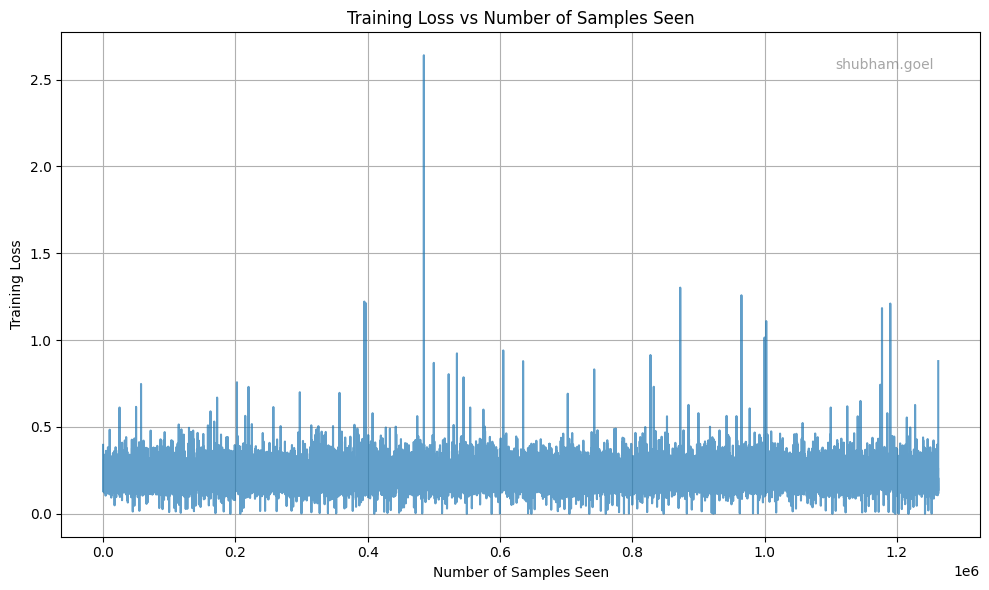

Results saved to runs/border/batch_64_gradacc_8/
Model accuracy: 91.44%


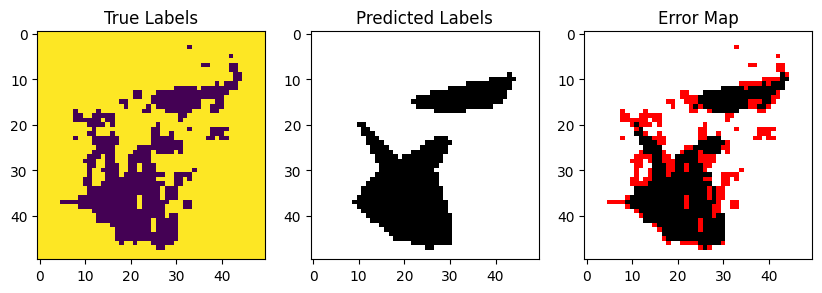

Time taken: 3.89 seconds
train_loss: 0.2308995609719358, accuracy: 91.44%
Running with batch size 128 and grad accumulation 1
Model created with 105 parameters.
Starting training: border/batch_128_gradacc_1
Early stopping at epoch 501
Training completed: 502 epochs, 1255000 samples
Final loss: 0.215367


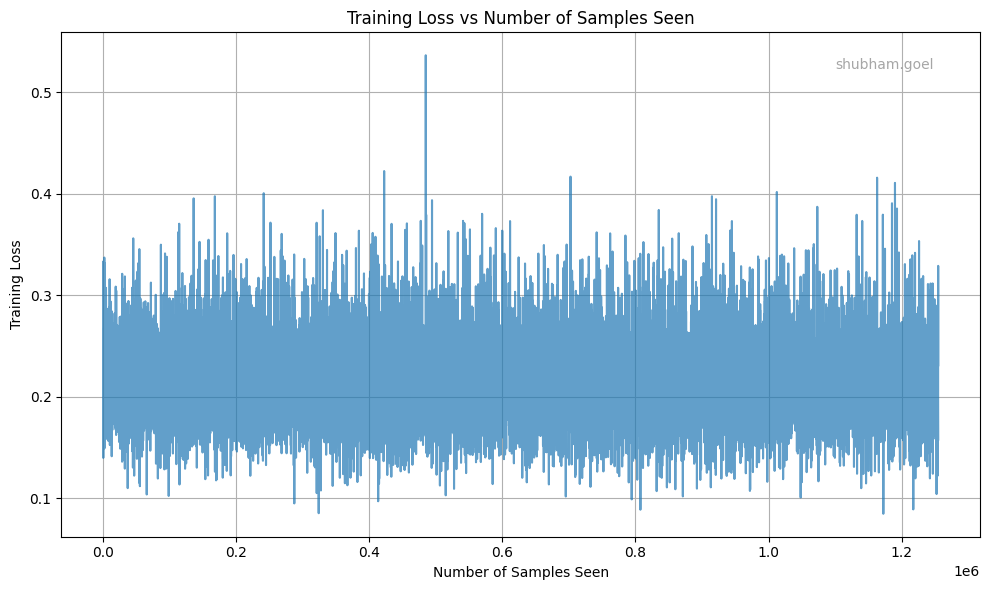

Results saved to runs/border/batch_128_gradacc_1/
Model accuracy: 91.12%


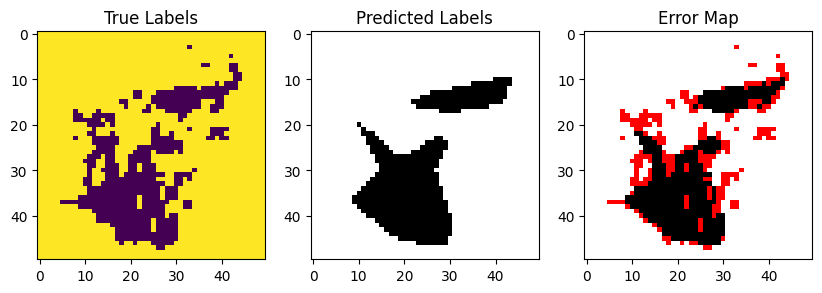

Time taken: 2.81 seconds
train_loss: 0.21536700012175994, accuracy: 91.12%
Running with batch size 128 and grad accumulation 2
Model created with 105 parameters.
Starting training: border/batch_128_gradacc_2
Early stopping at epoch 501
Training completed: 502 epochs, 1255000 samples
Final loss: 0.215283


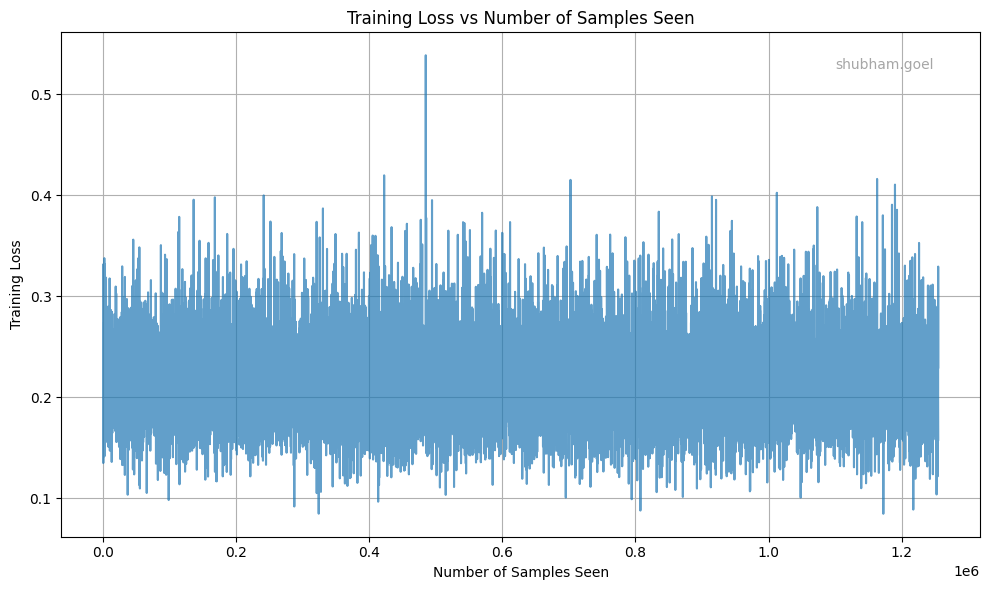

Results saved to runs/border/batch_128_gradacc_2/
Model accuracy: 91.16%


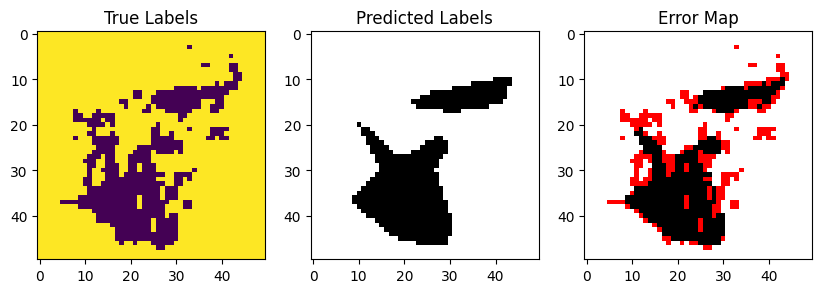

Time taken: 2.91 seconds
train_loss: 0.21528282404986027, accuracy: 91.16%
Running with batch size 128 and grad accumulation 4
Model created with 105 parameters.
Starting training: border/batch_128_gradacc_4
Early stopping at epoch 501
Training completed: 502 epochs, 1255000 samples
Final loss: 0.215262


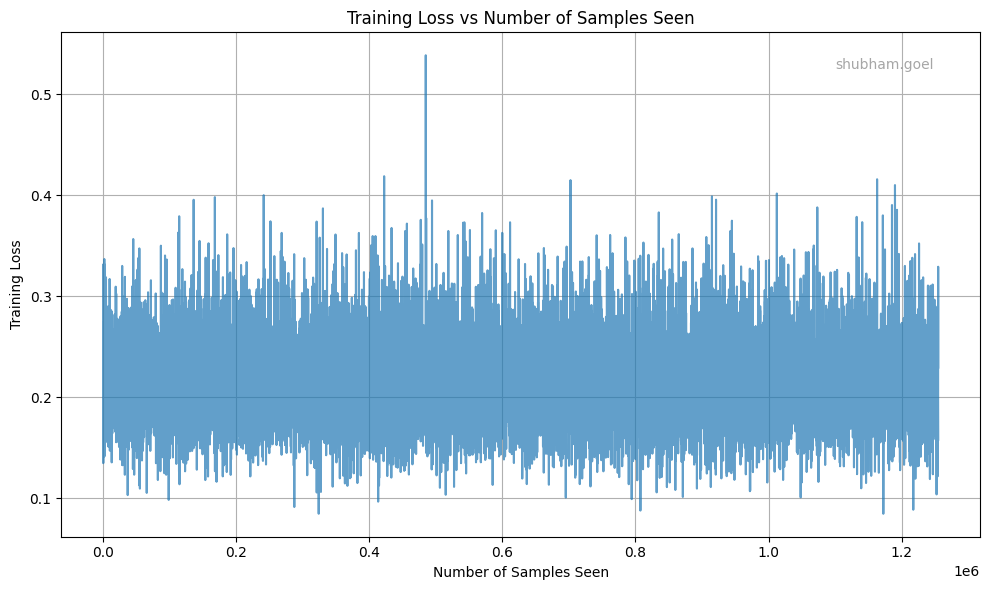

Results saved to runs/border/batch_128_gradacc_4/
Model accuracy: 91.12%


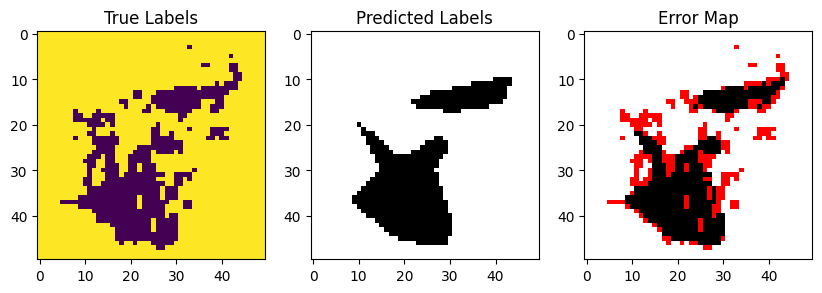

Time taken: 2.67 seconds
train_loss: 0.21526168868218248, accuracy: 91.12%
Running with batch size 128 and grad accumulation 8
Model created with 105 parameters.
Starting training: border/batch_128_gradacc_8
Early stopping at epoch 501
Training completed: 502 epochs, 1255000 samples
Final loss: 0.215264


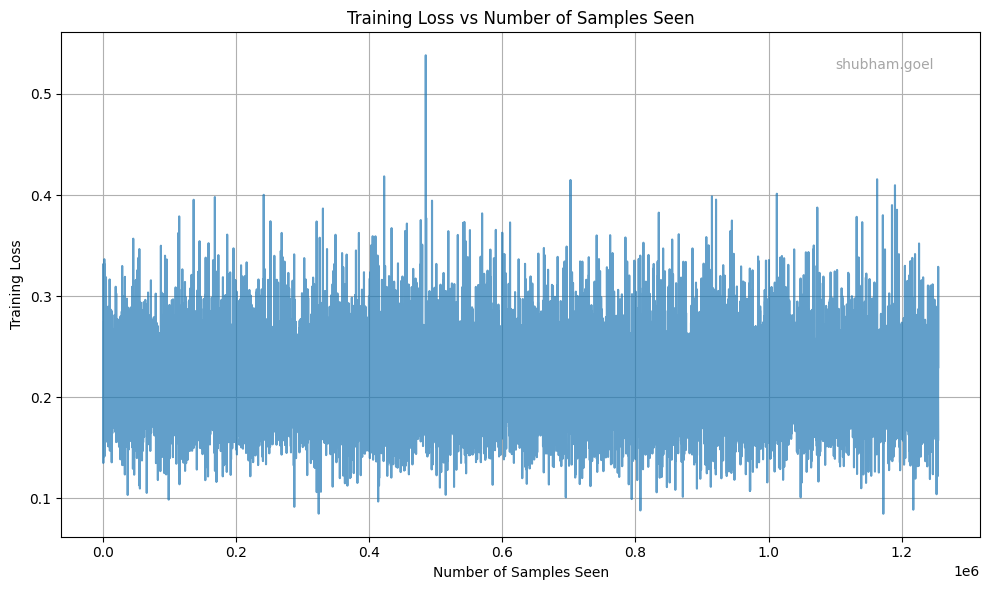

Results saved to runs/border/batch_128_gradacc_8/
Model accuracy: 91.12%


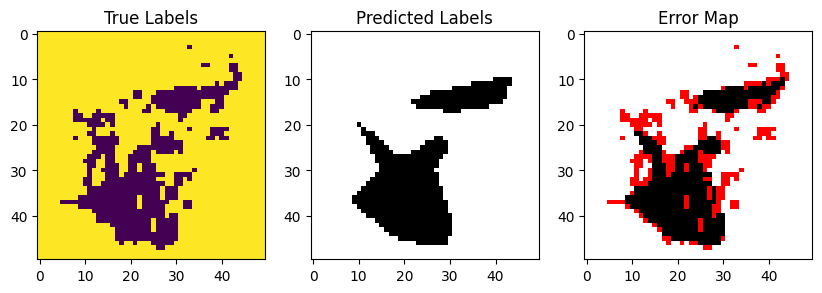

Time taken: 2.68 seconds
train_loss: 0.21526418183590632, accuracy: 91.12%


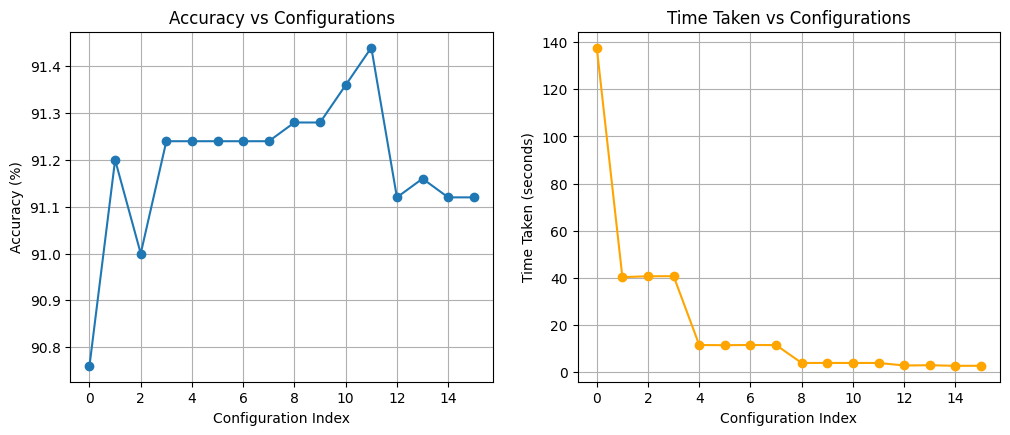

In [5]:
import time
layers = [
    Linear(input_size=2, output_size=8, activation_function=ReLU(), learning_rate=0.01),
    Linear(input_size=8, output_size=8, activation_function =ReLU(), learning_rate=0.01),
    Linear(input_size=8, output_size=1, activation_function=Sigmoid(), learning_rate=0.01)
]

model = Model(layers, BCELoss())

BATCH_SIZES = [4, 16, 64, 128]
GRAD_ACCUMULATION_STEPS = [1, 2, 4, 8]

accuracy_results = []
train_losses = []
samples_seen = []
time_list = []

for batch_size in BATCH_SIZES:
    for grad_accumulation in GRAD_ACCUMULATION_STEPS:
        print(f"Running with batch size {batch_size} and grad accumulation {grad_accumulation}")
        time_start = time.time()
        result = run_model_on_border(
            layers=layers,
            loss_fn=BCELoss(),
            learning_rate=0.01,
            max_epochs=10000,
            mask=mask,
            batch_size=batch_size,
            patience=500,
            rel_loss_threshold=1e-6,
            run_name=f"border/batch_{batch_size}_gradacc_{grad_accumulation}",
            save_model=True,
            learning_rate_=0.01
        )
        time_end = time.time()
        time_taken = time_end - time_start
        print(f"Time taken: {time_taken:.2f} seconds")
        print(f"train_loss: {result['final_loss']}, accuracy: {result['accuracy']*100:.2f}%")
        accuracy_results.append(result['accuracy'] * 100)
        train_losses.append(result['final_loss'])
        samples_seen.append(result['samples_seen'])
        time_list.append(time_taken)

# Plotting accuracy and training loss vs batch size and grad accumulation steps
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.plot(range(len(accuracy_results)), accuracy_results, marker='o')
plt.title("Accuracy vs Configurations")
plt.xlabel("Configuration Index")
plt.ylabel("Accuracy (%)")
plt.grid()  

#plotting time taken and samples seen vs batch size and grad accumulation steps
plt.subplot(2, 2, 2)
plt.plot(range(len(time_list)), time_list, marker='o', color='orange')
plt.title("Time Taken vs Configurations")
plt.xlabel("Configuration Index")
plt.ylabel("Time Taken (seconds)")
plt.grid()  
